<a href="https://colab.research.google.com/github/sermelo/CNN_LSTM_stock_predictions/blob/main/Stock_market_mix_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import tarfile
from shutil import copyfile, move, copytree
import os

DATA_DIR = 'stock_data'
if not os.path.isdir(DATA_DIR):
    drive.mount('/gdrive')
    org_drive_files = '/gdrive/My Drive/Master Big Data/TFM2/stock_data/'
    copytree(org_drive_files, DATA_DIR)

Mounted at /gdrive


In [2]:
!ls stock_data

aapl.csv       csco.csv       hon.csv	     mcd.csv	    trv.csv
aapl_news.csv  csco_news.csv  hon_news.csv   mcd_news.csv   trv_news.csv
amgn.csv       cvx.csv	      ibm.csv	     mmm.csv	    unh.csv
amgn_news.csv  cvx_news.csv   ibm_news.csv   mmm_news.csv   unh_news.csv
axp.csv        dis.csv	      intc.csv	     mrk.csv	    v.csv
axp_news.csv   dis_news.csv   intc_news.csv  mrk_news.csv   v_news.csv
ba.csv	       dow.csv	      jnj.csv	     msft.csv	    vz.csv
ba_news.csv    dow_news.csv   jnj_news.csv   msft_news.csv  vz_news.csv
cat.csv        gs.csv	      jpm.csv	     nke.csv	    wba.csv
cat_news.csv   gs_news.csv    jpm_news.csv   nke_news.csv   wba_news.csv
crm.csv        hd.csv	      ko.csv	     pg.csv	    wmt.csv
crm_news.csv   hd_news.csv    ko_news.csv    pg_news.csv    wmt_news.csv


In [3]:
import os
import random
import pytz
import math
from math import sqrt
from datetime import datetime

import matplotlib.pyplot as plt
from IPython.display import display, HTML, Image

import pandas as pd
import numpy as np
import statistics
from scipy import stats

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import plot_model
from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, AveragePooling2D, MaxPooling2D, Flatten, Embedding, concatenate, TimeDistributed
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
DJI_INDEX = ['mmm', 'axp', 'amgn', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko', 'dow', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'mcd', 'mrk', 'msft', 'nke', 'pg', 'crm', 'trv', 'unh', 'vz', 'v', 'wba', 'wmt', 'dis']
SYMBOLS = DJI_INDEX

#FIRST_DATE = pd.Timestamp('2015-01-02') # Monday
FIRST_DATE = pd.Timestamp('2014-01-02', tz=pytz.utc) # Monday
LAST_DATE = pd.Timestamp('2019-12-31', tz=pytz.utc) # Friday

print(f'Number of companies: {len(SYMBOLS)}')

Number of companies: 30


In [5]:
def company_to_file(company):
    file_name = f'{company}.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def company_to_news_file(company):
    file_name = f'{company}_news.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def date_utc(s):
    return parse(s, tzinfos=tzutc)

def get_df(file_path):
    data = pd.read_csv(file_path, parse_dates=['Date'])
    #data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    data = data.drop(['Adj Close'], axis=1)
    #data["Rel_Open"] = ((data["Open"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_High"] = ((data["High"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_Low"] = ((data["Low"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100

    data["Rel_Close"] = (data["Close"].diff(1) / data["Close"].shift(1)) * 100
    data["One_day_Y"] = (-data["Close"].diff(-1) / data["Close"]) * 100
    data["month_Y"] = (-data["Close"].diff(-21) / data["Close"]) * 100
    data["6_months_Y"] = (-data["Close"].diff(-126) / data["Close"]) * 100
    data["year_Y"] = (-data["Close"].diff(-252) / data["Close"]) * 100
    #(data["Close"].shift(-1))
    #data = data.iloc[1:] # First row doesn't contain percentage
    #print(data)
    data['Date'] = data['Date'].dt.tz_localize(pytz.utc)
    data = data[data['Date'] >= FIRST_DATE]
    data = data[data['Date'] <= LAST_DATE]
    data = data.drop(['Close'], axis=1)
    #print(data)
    #print(data.iloc[0]['Date'])
    #print(data.iloc[-1]['Date'])
    return data    
    
def get_data_dict():
    data_dict = {}
    for symbol in SYMBOLS:
        file_name = company_to_file(symbol)
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f'File {file_name} skipped because it doesn\'t exist')
        elif os.stat(file_path).st_size == 0:
            print(f'File {file_name} skipped because it is empty')
        else:
            #print(f'File {file_name}')
            data = get_df(file_path)
            if data.iloc[0]['Date'] != FIRST_DATE:
                print(f'File {file_name} doesn\'t have enough data({data.shape[0]}). It starts on {data.iloc[0]["Date"]} and should start on {FIRST_DATE}')
            elif data.iloc[-1]['Date'] != LAST_DATE:
                print(f'File {file_name} doesn\'t have data until {LAST_DATE.date()}')            
            else:
                print(f'File {file_name} added. Contains {data.shape[0]} rows')
                data_dict[symbol] = data
            #display(data_dict[symbol])
        #break
    return data_dict


def get_max(stocks, column):
    max = 0
    for symbol in stocks.keys():
        stock_max = stocks[symbol][column].max()
        if stock_max > max:
            max = stock_max
    return max

def get_min(stocks, column):
    min = 0
    for symbol in stocks.keys():
        stock_min = stocks[symbol][column].min()
        if stock_min < min:
            min = stock_min
    return min

def normalize(stock, column):
    max_value = stock[column].max()
    min_value = stock[column].min()
    divisor = max(max_value, -min_value)
    stock[column] = stock[column]/divisor
    return divisor

def normalize_all(stocks, normalization_values, column):
    for symbol in stocks.keys():
        divisor = normalize(stocks[symbol], column)
        if symbol not in normalization_values:
            normalization_values[symbol] = {}
        normalization_values[symbol][column] = divisor
    
stocks_data = get_data_dict()
print(f'Number of companies loaded: {len(stocks_data)}')
display(stocks_data['aapl'])

normalization_values = {}
print(stocks_data.keys())
normalize_all(stocks_data, normalization_values, "One_day_Y")
normalize_all(stocks_data, normalization_values, "month_Y")
normalize_all(stocks_data, normalization_values, "6_months_Y")
normalize_all(stocks_data, normalization_values, "year_Y")

display(stocks_data['aapl'])

File mmm.csv added. Contains 1510 rows
File axp.csv added. Contains 1510 rows
File amgn.csv added. Contains 1510 rows
File aapl.csv added. Contains 1510 rows
File ba.csv added. Contains 1510 rows
File cat.csv added. Contains 1510 rows
File cvx.csv added. Contains 1510 rows
File csco.csv added. Contains 1510 rows
File ko.csv added. Contains 1510 rows
File dow.csv doesn't have enough data(199). It starts on 2019-03-20 00:00:00+00:00 and should start on 2014-01-02 00:00:00+00:00
File gs.csv added. Contains 1510 rows
File hd.csv added. Contains 1510 rows
File hon.csv added. Contains 1510 rows
File ibm.csv added. Contains 1510 rows
File intc.csv added. Contains 1510 rows
File jnj.csv added. Contains 1510 rows
File jpm.csv added. Contains 1510 rows
File mcd.csv added. Contains 1510 rows
File mrk.csv added. Contains 1510 rows
File msft.csv added. Contains 1510 rows
File nke.csv added. Contains 1510 rows
File pg.csv added. Contains 1510 rows
File crm.csv added. Contains 1510 rows
File trv.csv 

,Date,Open,High,Low,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,19.845715,19.893929,19.715000,234684800,-1.406368,-2.196582,-9.328729,18.997348,38.359885
22,2014-01-03 00:00:00+00:00,19.745001,19.775000,19.301071,392467600,-2.196582,0.545301,-5.950313,24.180187,37.481972
23,2014-01-06 00:00:00+00:00,19.194643,19.528572,19.057142,412610800,0.545301,-0.715157,-5.761767,22.708807,36.749222
24,2014-01-07 00:00:00+00:00,19.440001,19.498571,19.211428,317209200,-0.715157,0.633282,-5.097779,23.644538,39.665572
25,2014-01-08 00:00:00+00:00,19.243214,19.484285,19.238928,258529600,0.633282,-1.277007,-4.375674,22.415631,44.119160
...,...,...,...,...,...,...,...,...,...,...
1526,2019-12-24 00:00:00+00:00,71.172501,71.222504,70.730003,48478800,0.095066,1.984035,8.681896,28.342777,NaN
1527,2019-12-26 00:00:00+00:00,71.205002,72.495003,71.175003,93121200,1.984035,-0.037948,9.582284,21.979235,NaN
1528,2019-12-27 00:00:00+00:00,72.779999,73.492500,72.029999,146266000,-0.037948,0.593513,11.918568,24.837824,NaN
1529,2019-12-30 00:00:00+00:00,72.364998,73.172501,71.305000,144114400,0.593513,0.730655,11.097012,25.137213,NaN


dict_keys(['mmm', 'axp', 'amgn', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'mcd', 'mrk', 'msft', 'nke', 'pg', 'crm', 'trv', 'unh', 'vz', 'v', 'wba', 'wmt', 'dis'])


,Date,Open,High,Low,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,19.845715,19.893929,19.715000,234684800,-1.406368,-0.220524,-0.434999,0.292642,0.238373
22,2014-01-03 00:00:00+00:00,19.745001,19.775000,19.301071,392467600,-2.196582,0.054745,-0.277463,0.372480,0.232918
23,2014-01-06 00:00:00+00:00,19.194643,19.528572,19.057142,412610800,0.545301,-0.071798,-0.268671,0.349814,0.228364
24,2014-01-07 00:00:00+00:00,19.440001,19.498571,19.211428,317209200,-0.715157,0.063578,-0.237709,0.364229,0.246487
25,2014-01-08 00:00:00+00:00,19.243214,19.484285,19.238928,258529600,0.633282,-0.128204,-0.204038,0.345298,0.274162
...,...,...,...,...,...,...,...,...,...,...
1526,2019-12-24 00:00:00+00:00,71.172501,71.222504,70.730003,48478800,0.095066,0.199186,0.404837,0.436602,NaN
1527,2019-12-26 00:00:00+00:00,71.205002,72.495003,71.175003,93121200,1.984035,-0.003810,0.446822,0.338576,NaN
1528,2019-12-27 00:00:00+00:00,72.779999,73.492500,72.029999,146266000,-0.037948,0.059585,0.555763,0.382611,NaN
1529,2019-12-30 00:00:00+00:00,72.364998,73.172501,71.305000,144114400,0.593513,0.073353,0.517454,0.387222,NaN


In [6]:
from nltk.tokenize import word_tokenize 
import nltk
nltk.download('punkt')
from collections import Counter

def company_to_news_file(company):
    file_name = f'{company}_news.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def get_news_df(file_path):
    data = pd.read_csv(file_path, parse_dates=['date'])
    data = data.sort_values(by=['date'])

    if data.iloc[0]["date"].date() > FIRST_DATE.date():
        exc_message = f'File {file_path} doesn\'t have enough data({data.shape[0]}). It starts on {data.iloc[0]["date"].date()} and should start on {FIRST_DATE.date()}'
        print(exc_message)
        raise ValueError(exc_message)
    elif data.iloc[-1]['date'].date() < LAST_DATE.date():
        exc_message = f'File {file_path} doesn\'t have data until {LAST_DATE.date()}'
        print(exc_message)
        raise ValueError(exc_message)

    #print(f'File {file_path} added. Contains {data.shape[0]} rows')
    data = data[data['date'] >= FIRST_DATE]
    data = data[data['date'] <= LAST_DATE + pd.DateOffset(1)]
    #data['title'] = word_tokenize(data['title'])
    data['title'] = data.apply(lambda row: nltk.word_tokenize(row['title']), axis=1)
    #print(data)
    #print(data.iloc[0]['Date'])
    #print(data.iloc[-1]['Date'])
    return data

def get_news_data_dict():
    data_dict = {}
    for symbol in SYMBOLS:
        file_name = company_to_news_file(symbol)
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f'File {file_name} skipped because it doesn\'t exist')
        elif os.stat(file_path).st_size == 0:
            print(f'File {file_name} skipped because it is empty')
        else:
            #print(f'File {file_name}')
            try:
                data = get_news_df(file_path)
            except ValueError:
                print(f'File {file_name} doesn\'t contain the needed data')
                continue
            #display(data)
            print(f'File {file_name} added. Contains {data.shape[0]} rows')
            data_dict[symbol] = data
            
        #break
    return data_dict

###############################################################
###############################################################
###############################################################

def create_labels(data):
    all_words = []
    for df in data.values():
        for index, row in df.iterrows():
            #print(row['title'])
            all_words.extend(row['title'])
        #print(len(all_words))
    #print(len(all_words))
    unique_words = list(set(all_words))
    #print(len(unique_words))
    words_dict = {}
    for i in range(0, len(unique_words)):
        words_dict[unique_words[i]] = i + 1 # Leave 0 label for other purposes
    #print(words_dict)
    return words_dict

def add_numeric_words(data, labels):
    def numerize(word):
        return labels[word]
    for df in data.values():
        df['title_num'] = df.apply(lambda row: list(map(numerize, row['title'])), axis=1)



raw_stocks_news_data = get_news_data_dict()
display(raw_stocks_news_data['aapl'])
labels = create_labels(raw_stocks_news_data)
add_numeric_words(raw_stocks_news_data, labels)
display(raw_stocks_news_data['aapl'])
print(f'Number of companies loaded: {len(raw_stocks_news_data)}')
print(f'Number of unique words: {len(labels)}')
#print(NEWS_DATA_DICT.keys())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
File mmm_news.csv added. Contains 226 rows
File axp_news.csv added. Contains 416 rows
File amgn_news.csv added. Contains 832 rows
File aapl_news.csv added. Contains 2474 rows
File ba_news.csv added. Contains 2170 rows
File cat_news.csv added. Contains 496 rows
File cvx_news.csv added. Contains 1269 rows
File csco_news.csv added. Contains 506 rows
File ko_news.csv added. Contains 586 rows
File stock_data/dow_news.csv doesn't have enough data(75). It starts on 2019-05-15 and should start on 2014-01-02
File dow_news.csv doesn't contain the needed data
File gs_news.csv added. Contains 1046 rows
File hd_news.csv added. Contains 337 rows
File hon_news.csv added. Contains 433 rows
File ibm_news.csv added. Contains 588 rows
File intc_news.csv added. Contains 992 rows
File jnj_news.csv added. Contains 1158 rows
File jpm_news.csv added. Contains 1252 rows
File mcd_news.csv added. Contains 85

,id,date,title,comments
2968,1488011,2014-01-02 12:39:10+00:00,"[Apple, downgraded, at, Wells, over, margin, c...",28
2967,1488861,2014-01-02 16:26:13+00:00,"[Cantor, 's, White, calls, Apple, ,, Splunk, ,...",8
2966,1491731,2014-01-05 07:07:50+00:00,"[U.S., tech, giants, enjoy, U.K., ``, tax, bon...",34
2965,1492171,2014-01-06 12:43:32+00:00,"[Apple, cut, to, Sell, at, Standpoint, over, m...",140
2964,1495031,2014-01-07 14:12:35+00:00,"[2013, iOS, App, Store, sales, top, $, 10B]",19
...,...,...,...,...
499,3528693,2019-12-30 12:38:21+00:00,"[Apple, 'clear, winner, ', ahead, of, 5G, -, W...",97
498,3528760,2019-12-30 15:55:20+00:00,"[Wedbush, sees, strengthening, FAANG, vertical...",39
497,3528803,2019-12-30 19:33:32+00:00,"[Citi, sees, Apple, wearables, strength, in, 2...",13
496,3528989,2019-12-31 20:44:33+00:00,"[Hardware, stocks, underperformed, in, 2019]",9


,id,date,title,comments,title_num
2968,1488011,2014-01-02 12:39:10+00:00,"[Apple, downgraded, at, Wells, over, margin, c...",28,"[13505, 12743, 10333, 7736, 12425, 10305, 9719]"
2967,1488861,2014-01-02 16:26:13+00:00,"[Cantor, 's, White, calls, Apple, ,, Splunk, ,...",8,"[13647, 6975, 13127, 6005, 13505, 14117, 17958..."
2966,1491731,2014-01-05 07:07:50+00:00,"[U.S., tech, giants, enjoy, U.K., ``, tax, bon...",34,"[563, 234, 16937, 15965, 13494, 1077, 3021, 15..."
2965,1492171,2014-01-06 12:43:32+00:00,"[Apple, cut, to, Sell, at, Standpoint, over, m...",140,"[13505, 4400, 11116, 7188, 10333, 14570, 12425..."
2964,1495031,2014-01-07 14:12:35+00:00,"[2013, iOS, App, Store, sales, top, $, 10B]",19,"[8273, 6955, 8700, 16176, 4603, 12126, 23, 1928]"
...,...,...,...,...,...
499,3528693,2019-12-30 12:38:21+00:00,"[Apple, 'clear, winner, ', ahead, of, 5G, -, W...",97,"[13505, 4447, 2601, 2494, 7763, 10790, 7364, 7..."
498,3528760,2019-12-30 15:55:20+00:00,"[Wedbush, sees, strengthening, FAANG, vertical...",39,"[16005, 264, 2852, 17248, 6404, 14652, 4089]"
497,3528803,2019-12-30 19:33:32+00:00,"[Citi, sees, Apple, wearables, strength, in, 2...",13,"[3771, 264, 13505, 8823, 5842, 14652, 4089]"
496,3528989,2019-12-31 20:44:33+00:00,"[Hardware, stocks, underperformed, in, 2019]",9,"[8728, 12796, 6386, 14652, 4570]"


Number of companies loaded: 29
Number of unique words: 18174


24811


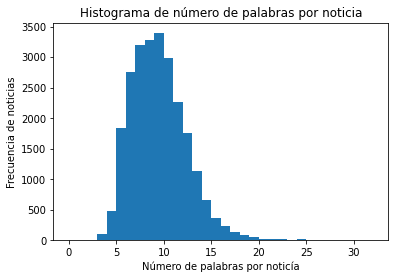

Max words: 32
Mean words: 8.981661359880698


In [7]:
words_news = []
for df in raw_stocks_news_data.values():
    for index, row in df.iterrows():
            words_news.append(len(row['title_num']))
words_news
print(len(words_news))
plt.hist(words_news,# 20,
         #density=True,
         histtype='bar',
         bins=range(0, max(words_news) + 1)
         )
plt.xlabel('Número de palabras por noticía')
plt.ylabel('Frecuencia de noticias')
plt.title('Histograma de número de palabras por noticia')
plt.show()
print(f'Max words: {max(words_news)}')
print(f'Mean words: {np.mean(words_news)}')

#print(words_news)

In [8]:
def news_by_day_df(data):
    #FIRST_DATE = pd.Timestamp('2014-01-02', tz=pytz.utc) # Monday
    #LAST_DATE = pd.Timestamp('2019-12-31', tz=pytz.utc) # Friday
    WORDS_PER_DAY = 30
    new_data = {}
    for company in data.keys():
        df = data[company]
        new_df = pd.DataFrame(columns=['Date', 'News'])
        date_iterator = FIRST_DATE
        while date_iterator <= LAST_DATE:
            next_date = date_iterator + pd.DateOffset(1)
            while not True in (stocks_data[company]['Date'] == next_date).value_counts() and date_iterator != LAST_DATE:
                #print(f'NO DATA FOR THAT DAY: {next_date.weekday()}')
                next_date = next_date + pd.DateOffset(1)
                
            mask = (df['date'] >= date_iterator) & (df['date'] < next_date)
            rows = df.loc[mask]
            words = []
            for index, row in df.loc[mask].iterrows():
                #print(row)
                words.extend(row['title_num'])
            new_df = new_df.append({'Date': date_iterator, 'News': words}, ignore_index=True)
            #print(f'New DF: {new_df}')
            date_iterator = next_date
            #break
        new_data[company] = new_df
    return new_data

analyzing_data = news_by_day_df(raw_stocks_news_data)



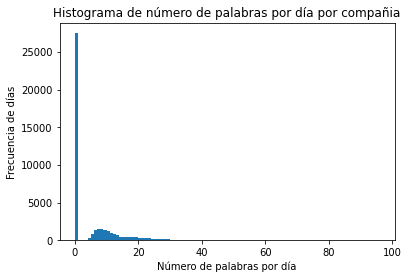

Max words: 96
Mean words: 5.088924411966202
Mode words: 0
Median words: 0.0


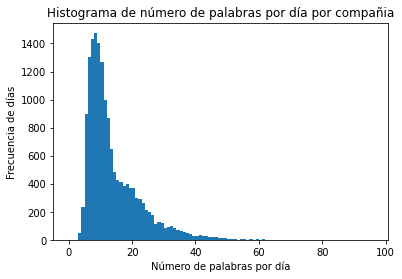

Max words: 96
Mean words: 13.652147276848618
Mode words: 8
Median words: 11.0


In [9]:
words_news = []
for df in analyzing_data.values():
    for index, row in df.iterrows():
            words_news.append(len(row['News']))
            #if(len(row['News']) == 0):
            #    print(row['Date'])

plt.hist(words_news,# 20,
         #density=True,
         histtype='bar',
         bins=range(0, max(words_news) + 1)
         )

plt.xlabel('Número de palabras por día')
plt.ylabel('Frecuencia de días')
plt.title('Histograma de número de palabras por día por compañia')

plt.show()


print(f'Max words: {max(words_news)}')
print(f'Mean words: {np.mean(words_news)}')
print(f'Mode words: {stats.mode(words_news)[0][0]}')
print(f'Median words: {np.median(words_news)}')

words_news = list(filter((0).__ne__, words_news)) 
plt.hist(words_news,# 20,
         #density=True,
         histtype='bar',
         bins=range(0, max(words_news) + 1)
         )
plt.xlabel('Número de palabras por día')
plt.ylabel('Frecuencia de días')
plt.title('Histograma de número de palabras por día por compañia')

plt.show()

print(f'Max words: {max(words_news)}')
print(f'Mean words: {np.mean(words_news)}')
print(f'Mode words: {stats.mode(words_news)[0][0]}')
print(f'Median words: {np.median(words_news)}')

Percentil 0: 3.0
Percentil 2: 5.0
Percentil 4: 5.0
Percentil 6: 5.0
Percentil 8: 6.0
Percentil 10: 6.0
Percentil 12: 6.0
Percentil 14: 6.0
Percentil 16: 7.0
Percentil 18: 7.0
Percentil 20: 7.0
Percentil 22: 7.0
Percentil 24: 7.0
Percentil 26: 8.0
Percentil 28: 8.0
Percentil 30: 8.0
Percentil 32: 8.0
Percentil 34: 9.0
Percentil 36: 9.0
Percentil 38: 9.0
Percentil 40: 9.0
Percentil 42: 10.0
Percentil 44: 10.0
Percentil 46: 10.0
Percentil 48: 10.0
Percentil 50: 11.0
Percentil 52: 11.0
Percentil 54: 11.0
Percentil 56: 12.0
Percentil 58: 12.0
Percentil 60: 12.0
Percentil 62: 13.0
Percentil 64: 13.0
Percentil 66: 14.0
Percentil 68: 15.0
Percentil 70: 15.0
Percentil 72: 16.0
Percentil 74: 17.0
Percentil 76: 18.0
Percentil 78: 19.0
Percentil 80: 19.0
Percentil 82: 20.0
Percentil 84: 21.0
Percentil 86: 22.0
Percentil 88: 24.0
Percentil 90: 25.0
Percentil 92: 27.0
Percentil 94: 30.0
Percentil 96: 34.0
Percentil 98: 40.0
Percentil 100: 96.0


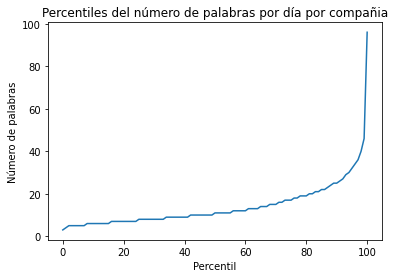

In [10]:
x = []
for i in range(0, 101, 2):
    print(f'Percentil {i}: {np.percentile(words_news, i)}')
    #x.append(np.percentile(words_news, i))
    pass
for i in range(0, 101, 1):
    #print(f'Percentil {i}: {np.percentile(words_news, i)}')
    x.append(np.percentile(words_news, i))

plt.plot(x)
plt.xlabel('Percentil')
plt.ylabel('Número de palabras')
plt.title('Percentiles del número de palabras por día por compañia')
plt.show()

In [11]:
def news_by_day_df(data):
    #FIRST_DATE = pd.Timestamp('2014-01-02', tz=pytz.utc) # Monday
    #LAST_DATE = pd.Timestamp('2019-12-31', tz=pytz.utc) # Friday
    #WORDS_PER_DAY = 30
    WORDS_PER_DAY = 25
    new_data = {}
    for company in data.keys():
        df = data[company]
        new_df = pd.DataFrame(columns=['Date', 'News'])
        date_iterator = FIRST_DATE
        while date_iterator <= LAST_DATE:
            #print(date_iterator)
            #if date_iterator.weekday() == 4:
            #    next_date = date_iterator + pd.DateOffset(3)
            #else:
            next_date = date_iterator + pd.DateOffset(1)
            while not True in (stocks_data[company]['Date'] == next_date).value_counts() and date_iterator != LAST_DATE:
                #print(f'NO DATA FOR THAT DAY: {next_date.weekday()}')
                next_date = next_date + pd.DateOffset(1)
                
            mask = (df['date'] >= date_iterator) & (df['date'] < next_date)
            #print(mask)
            rows = df.loc[mask]
            words = []
            for index, row in df.loc[mask].iterrows():
                #print(row)
                words.extend(row['title_num'])
            #print(rows)
            words = words[0:WORDS_PER_DAY]
            words.extend([0] * (WORDS_PER_DAY - len(words)))
            #words = np.asarray(words).astype(np.int16)
            #print(len(words))
            #words = words.reshape((words.shape[0], 1))
            #print(words.shape)
            new_df = new_df.append({'Date': date_iterator, 'News': words}, ignore_index=True)
            #print(f'New DF: {new_df}')
            date_iterator = next_date
            #break
        new_data[company] = new_df
    return new_data
#    for df in NEWS_DATA_DICT.values():

stocks_news_data = news_by_day_df(raw_stocks_news_data)
print(stocks_news_data['aapl'])


                          Date                                               News
0    2014-01-02 00:00:00+00:00  [13505, 12743, 10333, 7736, 12425, 10305, 9719...
1    2014-01-03 00:00:00+00:00  [563, 234, 16937, 15965, 13494, 1077, 3021, 15...
2    2014-01-06 00:00:00+00:00  [13505, 4400, 11116, 7188, 10333, 14570, 12425...
3    2014-01-07 00:00:00+00:00  [8273, 6955, 8700, 16176, 4603, 12126, 23, 192...
4    2014-01-08 00:00:00+00:00  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
...                        ...                                                ...
1505 2019-12-24 00:00:00+00:00  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1506 2019-12-26 00:00:00+00:00  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1507 2019-12-27 00:00:00+00:00  [12071, 17982, 6610, 12128, 11116, 13505, 1411...
1508 2019-12-30 00:00:00+00:00  [13505, 4447, 2601, 2494, 7763, 10790, 7364, 7...
1509 2019-12-31 00:00:00+00:00  [8728, 12796, 6386, 14652, 4570, 13505, 14117,...

[1510 rows x 2 

In [12]:
class Data_manager(object):
    def __init__(self, company_name, vector_size = 84, training_percentage = 0.8):
        self.company_name = company_name
        self.vector_size = vector_size
        self.training_percentage = training_percentage
        
    def __get_company_data(self, y_column):
        filter_data = stocks_data[self.company_name]
        dataset = filter_data.values
        X_data = []
        y_data = []
        for i in range(self.vector_size, len(dataset)+1):
            #last_days_data = dataset[i-self.vector_size:i, 1:6]
            last_days_data = dataset[i-self.vector_size:i, 5:6]
            y = filter_data[y_column].values[i-1]
            if math.isnan(y):
                continue
            X_data.append(last_days_data)
            y_data.append(y)
        X_data, y_data = np.asarray(X_data).astype(np.float32), np.asarray(y_data).astype(np.float32)
        return X_data, y_data

    def __get_company_news_data(self):
        filter_data = stocks_news_data[self.company_name]
        dataset = filter_data.values
        X_data = []
        for i in range(self.vector_size, len(dataset)+1):
            last_days_data = dataset[i-self.vector_size:i, 1]
            last_days_data=np.array([np.array(xi) for xi in last_days_data])
            X_data.append(last_days_data)        
        X_data = np.asarray(X_data).astype(np.int16)
        return X_data

    def __split_data(self, data):
        spliting_point = int(len(data) * self.training_percentage)
        return data[:spliting_point], data[spliting_point:]

    def get_processed_data(self, y_column = 'One_day_Y'):
        X_data, y_data = self.__get_company_data(y_column)
        X_train, X_test = self.__split_data(X_data)
        y_train, y_test = self.__split_data(y_data)
        X_news_data = self.__get_company_news_data()
        X_news_data = X_news_data[:len(X_data)]
        X_train_news, X_test_news = self.__split_data(X_news_data)
        return X_train, X_train_news, y_train, X_test, X_test_news, y_test

data_manager = Data_manager('aapl')
#X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data('year_Y')
X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data('One_day_Y')

print(f'Shape of train data: {X_train.shape}')
print(f'Shape of news train data: {X_train_news.shape}')
print(f'Shape of Y train data: {y_train.shape}')
print(f'Shape of test data: {X_test.shape}')
print(f'Shape of news test data: {X_test_news.shape}')
print(f'Shape of Y test data: {y_test.shape}')



Shape of train data: (1141, 84, 1)
Shape of news train data: (1141, 84, 25)
Shape of Y train data: (1141,)
Shape of test data: (286, 84, 1)
Shape of news test data: (286, 84, 25)
Shape of Y test data: (286,)


In [13]:
data_manager = Data_manager('mmm')
X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data('One_day_Y')

#display(stocks_data['mmm'][:85])
#display(X_train[0])
#display(y_train[0])

#X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data('year_Y')

#display(stocks_data['mmm'][:85])
#display(X_train[0])
#display(y_train[0])

In [14]:
class Model_manager(object):
    def __init__(self, price_input_shape, news_input_shape):
        self.price_input_shape = price_input_shape
        self.news_input_shape = news_input_shape
        self.model = self._get_model()
        self.callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)]

    def _get_model(self):
        pass
    
    def print_model(self):
        self.model.summary()
        plot_file_name = 'multiple_inputs.png'
        plot_model(self.model, to_file=plot_file_name)
        #Image(plot_file_name)
        display(Image(plot_file_name))

    def __prepare_data(self, data_manager):
        self.X_train_price, self.X_train_news, self.y_train, self.X_test_price, self.X_test_news, self.y_test = data_manager.get_processed_data(y_column)

    def train_model(self, data_manager, y_column, verbose=0):
        self.__prepare_data(data_manager)
        #print(self.X_train_price[0])
        #print(self.y_train[0])
        #print(self.X_test_price[0])
        #print(self.y_test[0])
        self.model.fit(self.get_train_data(), self.y_train, 
                  batch_size=10,
                  epochs=30,
                  callbacks=self.callbacks,
                  validation_data=(self.get_test_data(), self.y_test),
                  verbose=verbose)
        
    def get_train_data(self):
        return self.X_train_price

    def get_test_data(self):
        return self.X_test_price

    def predict(self):
        return self.model.predict(self.get_test_data())  

class CNN_price(Model_manager):  
    def _get_model(self):
        model = Sequential()
        model.add(Input(shape=self.price_input_shape, name="prices"))
        model.add(BatchNormalization())
        model.add(Conv1D(64, 5, activation='relu', input_shape=self.price_input_shape))
        model.add(AveragePooling1D(3))
        model.add(Dropout(0.4))
        model.add(Conv1D(64, 3, activation='relu'))
        model.add(AveragePooling1D(3))
        model.add(Dropout(0.4))
        model.add(Flatten())      
        model.add(Dropout(0.4))
        model.add(Dense(50))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='tanh'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        #model.summary()
        return model

class LSTM_price(Model_manager): 
    def _get_model(self):
        hidden_nodes = int(2* self.price_input_shape[0] * self.price_input_shape[1])
        model = Sequential()
        model.add(LSTM(hidden_nodes, return_sequences=False, recurrent_dropout=0.1, input_shape=self.price_input_shape))
        model.add(BatchNormalization())
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

class CNN_LSTM_price(Model_manager):
    def _get_model(self):
        hidden_nodes = int(2* self.price_input_shape[0] * self.price_input_shape[1])
        model = Sequential()
        model.add(Input(shape=self.price_input_shape, name="Input"))
        model.add(BatchNormalization(name="Normalization"))
        model.add(Conv1D(32, 3, activation="relu", input_shape=self.price_input_shape, name="Convolution"))
        model.add(AveragePooling1D(3, name="Pooling"))       
        model.add(LSTM(hidden_nodes, return_sequences=False, name="LSTM"))
        model.add(Dense(50, name="Fully_connected"))
        model.add(Dense(1, activation="tanh", name="Output"))
        model.compile(optimizer="adam", loss="mean_squared_error")
        return model

class CNN_news(Model_manager):
    def get_train_data(self):
        return self.X_train_news

    def get_test_data(self):
        return self.X_test_news

    def _get_model(self):
        model = Sequential()
        model.add(Input(shape=self.news_input_shape, name="Input"))
        model.add(Embedding(len(labels)+1, 8))
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(AveragePooling2D(3))
        model.add(Conv1D(64, 3, activation='relu'))
        model.add(AveragePooling2D(3))
        model.add(Flatten())
        model.add(Dropout(0.1))
        model.add(Dense(50))
        model.add(Dropout(0.1))
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        #model.summary()
        return model

class LSTM_news(CNN_news):
    def _get_model(self):
        hidden_nodes = int(2* self.news_input_shape[0] * self.news_input_shape[1])
        model = Sequential()
        model.add(Input(shape=self.news_input_shape, name="Input"))
        model.add(TimeDistributed(Embedding(len(labels)+1, 4), name='Timedistributed_Embedding'))
        model.add(TimeDistributed(LSTM(hidden_nodes, return_sequences=False), name='Timedistributed_LSTM'))
        model.add(Flatten())
        model.add(BatchNormalization())
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model

class CNN_LSTM_news(CNN_news):
    def _get_model(self):
        hidden_nodes = int(2* self.news_input_shape[0] * self.news_input_shape[1])
        model = Sequential()
        model.add(Input(shape=self.news_input_shape, name="Input"))
        model.add(TimeDistributed(Embedding(len(labels)+1, 4, name="Embedding"), name="Timedistributed_1"))
        model.add(Conv1D(32, 3, activation="relu", name="Convolucion"))
        model.add(AveragePooling2D(3, name="Pooling"))
        model.add(TimeDistributed(LSTM(hidden_nodes, return_sequences=False, name="LSTM"), name="Timedistributed_2"))
        model.add(Flatten(name="Flatten"))
        model.add(Dense(50, name="Fully_connected"))
        model.add(Dense(1, name="Output", activation="tanh"))
        model.compile(optimizer="adam", loss="mean_squared_error")
        return model

class CNN_LSTM_price_and_news(Model_manager):
    def get_train_data(self):
        return [self.X_train_price, self.X_train_news]

    def get_test_data(self):
        return [self.X_test_price, self.X_test_news]

    def _get_model(self):
        hidden_nodes = int(2* self.news_input_shape[0] * self.news_input_shape[1])

        price_input = Input(shape=self.price_input_shape, name="Prices_input")
        x1 = BatchNormalization(name="Normalization")(price_input)
        x1 = Conv1D(32, 3, activation='relu', name="Price_Convolution")(x1)
        x1 = AveragePooling1D(3, name="Price_Pooling")(x1)
        x1 = LSTM(hidden_nodes, return_sequences=False, name="Price_LSTM")(x1)
        x1 = Dense(50, name="Price_Fully_connected")(x1)
        x1 = Dense(1,  name="Price_Output", activation="tanh")(x1)

        news_input = Input(shape=self.news_input_shape, name="News_Input")
        x2 = TimeDistributed(Embedding(len(labels)+1, 4, name="Embedding"), name="Timedistributed_1")(news_input)
        x2 = Conv1D(32, 3, activation='relu', name="News_Convolution")(x2)
        x2 = AveragePooling2D(3, name="News_Pooling")(x2)
        x2 = TimeDistributed(LSTM(hidden_nodes, return_sequences=False, name="LSTM"), name="Timedistributed_2")(x2)
        x2 = Flatten(name="Flatten")(x2)
        x2 = Dense(50, name="News_Fully_connected")(x2)
        x2 = Dense(1,  name="News_Output", activation="tanh")(x2)

        merge = concatenate([x1, x2], name="Merge")
        #hidden1 = Dense(20, name="Merge_Fully_connected")(merge)
        output = Dense(1, name="Output", activation="tanh")(merge)
        
        model = Model(inputs=[price_input, news_input], outputs=output, name="price_predition")
        model.compile(optimizer="adam", loss="mean_squared_error")
        return model



Model: CNN_LSTM_price
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Normalization (BatchNormaliz (None, 84, 1)             4         
_________________________________________________________________
Convolution (Conv1D)         (None, 82, 32)            128       
_________________________________________________________________
Pooling (AveragePooling1D)   (None, 27, 32)            0         
_________________________________________________________________
LSTM (LSTM)                  (None, 168)               135072    
_________________________________________________________________
Fully_connected (Dense)      (None, 50)                8450      
_________________________________________________________________
Output (Dense)               (None, 1)                 51        
Total params: 143,705
Trainable params: 143,703
Non-trainable params: 2
____________________________

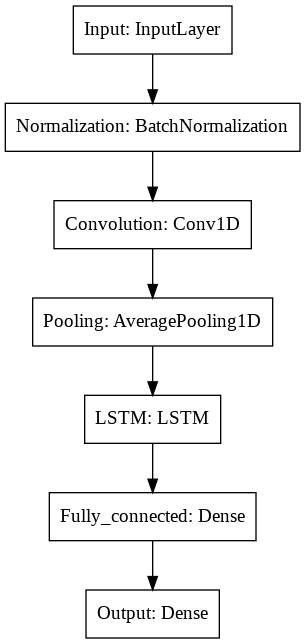

Model: CNN_LSTM_news
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Timedistributed_1 (TimeDistr (None, 84, 25, 4)         72700     
_________________________________________________________________
Convolucion (Conv1D)         (None, 84, 23, 32)        416       
_________________________________________________________________
Pooling (AveragePooling2D)   (None, 28, 7, 32)         0         
_________________________________________________________________
Timedistributed_2 (TimeDistr (None, 28, 4200)          71114400  
_________________________________________________________________
Flatten (Flatten)            (None, 117600)            0         
_________________________________________________________________
Fully_connected (Dense)      (None, 50)                5880050   
_________________________________________________________________
Output (Dense)               (Non

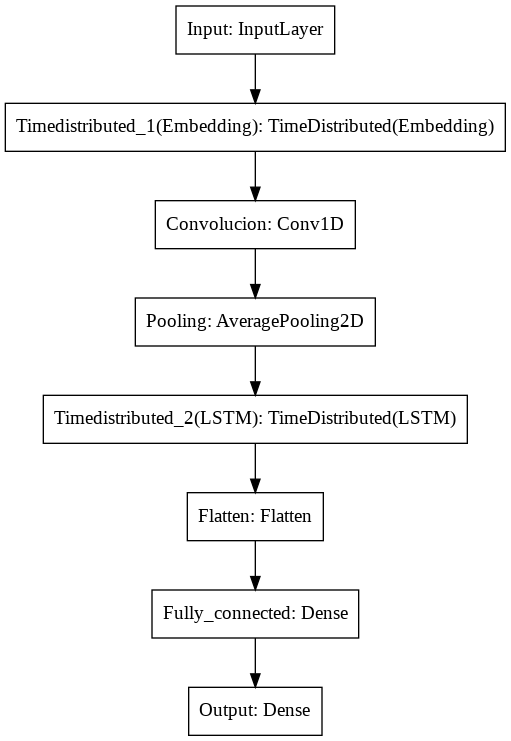

Model: CNN_LSTM_price_and_news
Model: "price_predition"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
News_Input (InputLayer)         [(None, 84, 25)]     0                                            
__________________________________________________________________________________________________
Prices_input (InputLayer)       [(None, 84, 1)]      0                                            
__________________________________________________________________________________________________
Timedistributed_1 (TimeDistribu (None, 84, 25, 4)    72700       News_Input[0][0]                 
__________________________________________________________________________________________________
Normalization (BatchNormalizati (None, 84, 1)        4           Prices_input[0][0]               
_____________________________________________________

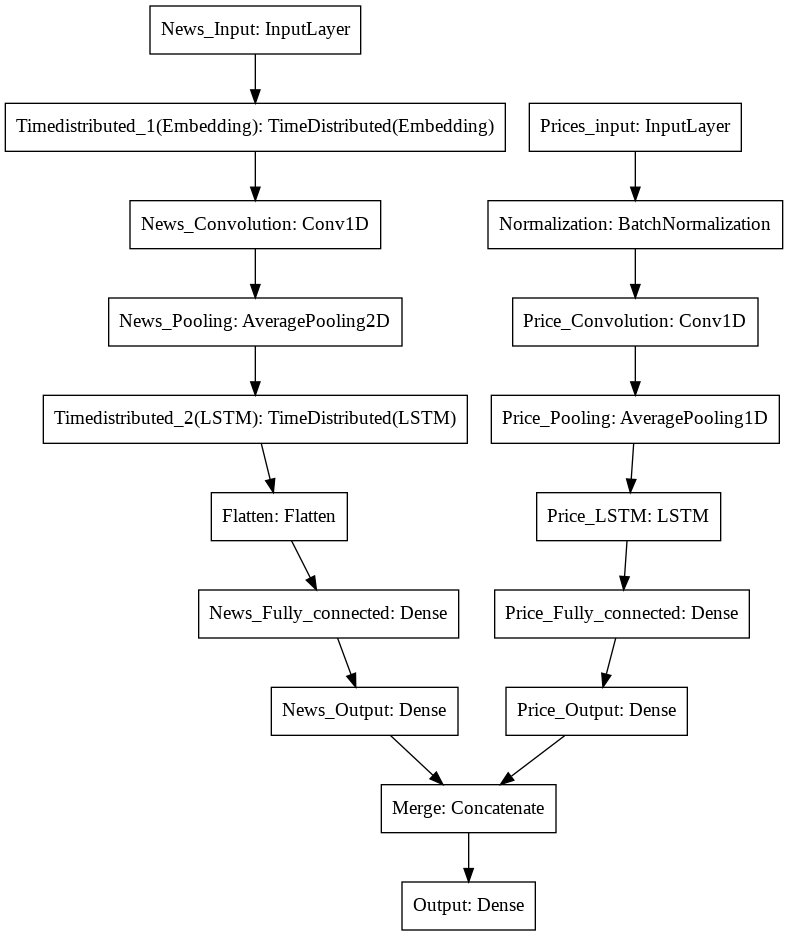

In [15]:
#all_models = [CNN_price]
all_models = [CNN_LSTM_price, CNN_LSTM_news, CNN_LSTM_price_and_news]
#all_models = [CNN_price, CNN_news, CNN_price_and_news]
X_train_price, X_train_news, y_train_price, X_test, X_test_news, y_test = data_manager.get_processed_data()
price_input_shape = (X_train_price.shape[1], X_train_price.shape[2])
news_input_shape = (X_train_news.shape[1], X_train_news.shape[2])
for model_class in all_models:
    model_manager = model_class(price_input_shape, news_input_shape)
    print(f'Model: {model_class.__name__}')
    model_manager.print_model()

In [16]:
def get_reference_predicions(company, y_column, X_test):
    mean = stocks_data[company][y_column].mean()
    #mean = X_test.mean()
    all_predictions = []
    for item in X_test:
        all_predictions.append(mean)
        #all_predictions.append(item.mean())

    return all_predictions

def get_reference_predicions(y_train, y_test):
    #mean = stocks_data[company][y_column].mean()
    #mean = X_test.mean()
    all_predictions = []
    #print(type(y_train))
    #print(y_train.shape)
    #print(y_test.shape)
    #print(np.concatenate((y_train, y_test), axis=0).shape)
    #mean = np.concatenate((y_train, y_test), axis=0).mean()
    mean = y_train.mean()
    for item in y_test:
        all_predictions.append(mean)
        #all_predictions.append(item.mean())
    print()
    return all_predictions

def get_reference_rmse_off_comanpies_data(companies, y_column, normalization_values):
    predictions_errors = {}
    for company in companies.keys():
        print(f'Company: {company}')
        data_manager = Data_manager(company)
        X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data(y_column)
        #ref_predictions = get_reference_predicions(company, y_train, X_test)
        ref_predictions = get_reference_predicions(y_train, y_test)
        #print(ref_predictions)
        #print(y_test)
        rmse = np.sqrt(np.mean(((ref_predictions - y_test) ** 2)))
        print(f'Reference prediction RMSE: {rmse}')
        predictions_errors[company] = rmse * normalization_values[company][y_column]
        print(f'Denormalized reference prediction RMSE: {predictions_errors[company]}')
    return predictions_errors

def get_rmse_off_comanpies_data(companies, model_class, y_column, normalization_values):
    predictions_errors = {}
    for company in companies.keys():
        print(f'Company: {company}')
        print(datetime.now().strftime("%H:%M:%S"))
        data_manager = Data_manager(company)
        X_train, X_train_news, y_train, X_test, X_test_news, y_test = data_manager.get_processed_data(y_column)
        input_shape = (X_train.shape[1], X_train.shape[2])
        news_input_shape = (X_train_news.shape[1], X_train_news.shape[2])
        #print(X_train.shape)
        model_manager = model_class(input_shape, news_input_shape)
        model_manager.train_model(data_manager, y_column, 0)
        predictions = model_manager.predict()
        
        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        print(f'{x.__class__.__name__} prediction RMSE: {rmse}')
        predictions_errors[company] = rmse * normalization_values[company][y_column]
        print(f'Denormalized {model_manager.__class__.__name__} prediction RMSE: {predictions_errors[company]}')
        #ref_predictions = get_reference_predicions(company, X_test)
        #ref_rmse = np.sqrt(np.mean(((ref_predictions - y_test) ** 2)))
        #print(f'Reference prediction RMSE: {ref_rmse}')
    return predictions_errors

In [17]:
#companies_data = dict(list(stocks_data.items())[:1])
all_models = []#CNN_LSTM_price_and_news]#, CNN_LSTM_price] #[LSTM_news]#CNN_news, LSTM_news]
#y_columns = ['year_Y']

companies_data = stocks_data
#all_models = [CNN_price, CNN_news, CNN_price_and_news]
y_columns = ['One_day_Y', 'month_Y', '6_months_Y', 'year_Y']

#companies_data = dict(list(stocks_data.items())[:5])
#companies_data = {'aapl': stocks_data['aapl']}

#reference_errors = get_reference_rmse_off_comanpies_data(companies_data)
print(f'Models to test: {all_models}')

rmse = {}
for y_column in y_columns:
    print(f'Getting data for {y_column}')
    rmse[y_column] = {}
    rmse[y_column]['reference'] = get_reference_rmse_off_comanpies_data(companies_data, y_column, normalization_values)

    for model_class in all_models:
        print(f'Model: {model_class.__name__}')
        rmse[y_column][model_class.__name__] = get_rmse_off_comanpies_data(companies_data, model_class, y_column, normalization_values)

for y_column in y_columns:
    for key, value in rmse[y_column].items():
        print(f'{y_column} - {key}: {value}')
        print(f'Average: {sum(value.values())/len(value)}')

Models to test: []
Getting data for One_day_Y
Company: mmm

Reference prediction RMSE: 0.1252141296863556
Denormalized reference prediction RMSE: 1.6209023236722335
Company: axp

Reference prediction RMSE: 0.10266293585300446
Denormalized reference prediction RMSE: 1.2423129962692077
Company: amgn

Reference prediction RMSE: 0.14481952786445618
Denormalized reference prediction RMSE: 1.3880391506163239
Company: aapl

Reference prediction RMSE: 0.18326790630817413
Denormalized reference prediction RMSE: 1.8254834303165839
Company: ba

Reference prediction RMSE: 0.19687405228614807
Denormalized reference prediction RMSE: 1.9450175339332134
Company: cat

Reference prediction RMSE: 0.1986488699913025
Denormalized reference prediction RMSE: 1.812891985068472
Company: cvx

Reference prediction RMSE: 0.20233003795146942
Denormalized reference prediction RMSE: 1.282218507638195
Company: csco

Reference prediction RMSE: 0.17172276973724365
Denormalized reference prediction RMSE: 1.6554349637042

In [18]:
print(rmse)


{'One_day_Y': {'reference': {'mmm': 1.6209023236722335, 'axp': 1.2423129962692077, 'amgn': 1.3880391506163239, 'aapl': 1.8254834303165839, 'ba': 1.9450175339332134, 'cat': 1.812891985068472, 'cvx': 1.282218507638195, 'csco': 1.655434963704213, 'ko': 1.094134725961904, 'gs': 1.6317228955937637, 'hd': 1.2656200578626684, 'hon': 1.1692791280447885, 'ibm': 1.3751894513790688, 'intc': 1.782140100852378, 'jnj': 1.2369062052297102, 'jpm': 1.2633775730180912, 'mcd': 0.9854778222440623, 'mrk': 1.1935482815588552, 'msft': 1.4483967989548705, 'nke': 1.5402060737804186, 'pg': 1.099469318545957, 'crm': 1.938937023490309, 'trv': 1.1358520012671065, 'unh': 1.6269409090665998, 'vz': 1.0797619811546826, 'v': 1.332188456361452, 'wba': 1.7451721596242338, 'wmt': 1.0287393027386418, 'dis': 1.465342645819325}}, 'month_Y': {'reference': {'mmm': 7.603726585286497, 'axp': 5.301150884376213, 'amgn': 6.886678474412957, 'aapl': 8.850858119153832, 'ba': 9.212675224025435, 'cat': 7.9598934948268, 'cvx': 4.65942498

In [19]:
REFERENCE = {'One_day_Y': {'reference': {'mmm': 1.6209023236722335, 'axp': 1.2423129962692077, 'amgn': 1.3880391506163239, 'aapl': 1.8254834303165839, 'ba': 1.9450175339332134, 'cat': 1.812891985068472, 'cvx': 1.282218507638195, 'csco': 1.655434963704213, 'ko': 1.094134725961904, 'gs': 1.6317228955937637, 'hd': 1.2656200578626684, 'hon': 1.1692791280447885, 'ibm': 1.3751894513790688, 'intc': 1.782140100852378, 'jnj': 1.2369062052297102, 'jpm': 1.2633775730180912, 'mcd': 0.9854778222440623, 'mrk': 1.1935482815588552, 'msft': 1.4483967989548705, 'nke': 1.5402060737804186, 'pg': 1.099469318545957, 'crm': 1.938937023490309, 'trv': 1.1358520012671065, 'unh': 1.6269409090665998, 'vz': 1.0797619811546826, 'v': 1.332188456361452, 'wba': 1.7451721596242338, 'wmt': 1.0287393027386418, 'dis': 1.465342645819325}}, 'month_Y': {'reference': {'mmm': 7.603726585286497, 'axp': 5.301150884376213, 'amgn': 6.886678474412957, 'aapl': 8.850858119153832, 'ba': 9.212675224025435, 'cat': 7.9598934948268, 'cvx': 4.659424988035418, 'csco': 7.266491056917534, 'ko': 3.637687587239976, 'gs': 7.986300852705759, 'hd': 5.659471702164384, 'hon': 5.5324965392831045, 'ibm': 6.692301374916138, 'intc': 8.407814762777685, 'jnj': 5.0428560905705115, 'jpm': 6.129047784205104, 'mcd': 4.104082981945258, 'mrk': 4.371669800644258, 'msft': 4.41553635752344, 'nke': 5.817007409670854, 'pg': 3.5262523833260793, 'crm': 6.557002387030159, 'trv': 4.708255173084842, 'unh': 7.734084207696269, 'vz': 3.728748433135104, 'v': 4.137698647681246, 'wba': 8.766282982742085, 'wmt': 4.268608044653995, 'dis': 7.166820046167959}}, '6_months_Y': {'reference': {'mmm': 17.482406495013798, 'axp': 17.722511464873097, 'amgn': 15.043417249924394, 'aapl': 24.223363567679325, 'ba': 41.520858866472956, 'cat': 14.341591271338384, 'cvx': 16.96630283729311, 'csco': 20.28343781485601, 'ko': 12.443304743681539, 'gs': 13.830108556164475, 'hd': 12.536836763035938, 'hon': 16.596491326546783, 'ibm': 11.83035156461862, 'intc': 15.074257951182837, 'jnj': 7.9290824802406465, 'jpm': 19.599319996359707, 'mcd': 13.757287626009337, 'mrk': 8.736840222706837, 'msft': 12.770821001242254, 'nke': 10.786566845043676, 'pg': 13.03309247528576, 'crm': 12.452223760292078, 'trv': 19.778646682597618, 'unh': 13.84534866822591, 'vz': 6.2580144243162055, 'v': 11.42861682946896, 'wba': 21.930270402952278, 'wmt': 9.806420673791711, 'dis': 18.824168042671914}}, 'year_Y': {'reference': {'mmm': 22.30900347239779, 'axp': 23.958044556294023, 'amgn': 17.98384166310948, 'aapl': 65.3908838263193, 'ba': 70.4274855102476, 'cat': 17.75110968025671, 'cvx': 26.84490423582121, 'csco': 30.65439943052123, 'ko': 13.258919850593266, 'gs': 15.782192643856648, 'hd': 11.18949678940494, 'hon': 20.821580984393457, 'ibm': 12.568201176716023, 'intc': 15.144699963209444, 'jnj': 8.752662978484091, 'jpm': 25.313676918139226, 'mcd': 19.045568415573186, 'mrk': 11.44062924030612, 'msft': 23.721769885840867, 'nke': 14.831842278704972, 'pg': 19.775074794208642, 'crm': 24.416790230617263, 'trv': 25.13031794003976, 'unh': 19.07861525461732, 'vz': 6.530240779640763, 'v': 14.705329584757369, 'wba': 24.08968939958455, 'wmt': 13.927334029420384, 'dis': 19.81429831942918}}}
CNN_LSTM_PRICE_AND_NEWS = {'One_day_Y': {'reference': {'mmm': 1.6501106594734545, 'axp': 1.275497963891936, 'amgn': 1.4732577673335665, 'aapl': 2.0014224876256836, 'ba': 2.0648257891932627, 'cat': 1.8435959495523064, 'cvx': 1.2825259097367145, 'csco': 1.744516759527792, 'ko': 1.105116637999489, 'gs': 1.64812605338074, 'hd': 1.32477603550618, 'hon': 1.2132559765883055, 'ibm': 1.3834550819150286, 'intc': 1.8858398644994046, 'jnj': 1.2856420048158643, 'jpm': 1.343620665120396, 'mcd': 1.0608346004699165, 'mrk': 1.2613054844712797, 'msft': 1.7360944945080163, 'nke': 1.7270002492425587, 'pg': 1.1107016681942339, 'crm': 2.2129319682146926, 'trv': 1.1625037948940982, 'unh': 1.8006862834873492, 'vz': 1.0882695678629009, 'v': 1.5553923826634997, 'wba': 1.7677367138715163, 'wmt': 1.079067956752047, 'dis': 1.5427536888364624}, 'CNN_LSTM_price_and_news': {'mmm': 1.6272248816347803, 'axp': 1.2418882588046416, 'amgn': 1.3877803573960843, 'aapl': 1.8245600687560672, 'ba': 1.9421668423928538, 'cat': 1.8123593135030713, 'cvx': 1.2821966937154428, 'csco': 1.6547340974178577, 'ko': 1.0949537722513796, 'gs': 1.6326442845957108, 'hd': 1.2672545776835946, 'hon': 1.1817901116847993, 'ibm': 1.3734838921124979, 'intc': 1.781828774932667, 'jnj': 1.236581101764167, 'jpm': 1.2632116430238058, 'mcd': 0.9880924239820847, 'mrk': 1.1934895793726492, 'msft': 1.4478393680920334, 'nke': 1.5397333239313205, 'pg': 1.0967156909487787, 'crm': 1.9389252690915277, 'trv': 1.135786307158554, 'unh': 1.6244690550363858, 'vz': 1.07981462519419, 'v': 1.334445524519073, 'wba': 1.7487348828143456, 'wmt': 1.0286703646665054, 'dis': 1.4796725376339215}}, 'month_Y': {'reference': {'mmm': 7.563791721589571, 'axp': 5.274415833928833, 'amgn': 6.880274134497533, 'aapl': 8.706879674447508, 'ba': 9.212938131829558, 'cat': 7.938323710551058, 'cvx': 4.661373279315869, 'csco': 7.269188986153652, 'ko': 3.6643547817133806, 'gs': 7.938642955393795, 'hd': 5.709126790828709, 'hon': 5.570482245002944, 'ibm': 6.620429958010097, 'intc': 8.369903881385019, 'jnj': 5.024613640417174, 'jpm': 6.11962779613134, 'mcd': 4.100561383986023, 'mrk': 4.366026201255978, 'msft': 4.283013618507932, 'nke': 5.819766825720888, 'pg': 3.4108530466328726, 'crm': 6.5476971736035585, 'trv': 4.7093672790663526, 'unh': 7.6206084525402735, 'vz': 3.722779167372706, 'v': 4.080875987259029, 'wba': 8.712076685585236, 'wmt': 4.259056015553209, 'dis': 7.098476386029319}, 'CNN_LSTM_price_and_news': {'mmm': 7.779998230057863, 'axp': 5.24689743460911, 'amgn': 6.882677206903119, 'aapl': 8.76201229169741, 'ba': 9.06447315516606, 'cat': 7.94423402184635, 'cvx': 4.6586802709077455, 'csco': 7.2247640244914955, 'ko': 3.6175889649258175, 'gs': 7.944859573314916, 'hd': 6.007513611562835, 'hon': 5.527264316827133, 'ibm': 7.118182735908321, 'intc': 8.371285456842994, 'jnj': 5.0205664081751245, 'jpm': 6.114576847406924, 'mcd': 4.099048155932922, 'mrk': 4.357592885106376, 'msft': 4.3730778413833935, 'nke': 5.771075260335495, 'pg': 3.4282331219221795, 'crm': 6.538451832165077, 'trv': 4.707648535047945, 'unh': 7.716236026686642, 'vz': 3.718495829986597, 'v': 4.066098058491609, 'wba': 8.188737839654298, 'wmt': 4.237845161534888, 'dis': 7.130967366783895}}, '6_months_Y': {'reference': {'mmm': 14.49066221823028, 'axp': 17.500276773405734, 'amgn': 15.705646746594377, 'aapl': 25.824458512352358, 'ba': 35.293930387136825, 'cat': 13.622588788792774, 'cvx': 17.097994996505154, 'csco': 17.392613734349812, 'ko': 12.56489361440493, 'gs': 13.809293284113355, 'hd': 14.151472882995343, 'hon': 15.914477413168983, 'ibm': 11.62224501754349, 'intc': 15.793010586542815, 'jnj': 7.99599549116639, 'jpm': 18.90550139889449, 'mcd': 12.324225496292495, 'mrk': 8.509935093208128, 'msft': 18.7696432340526, 'nke': 11.307679350905277, 'pg': 13.842592691881586, 'crm': 10.977170964409648, 'trv': 18.940384129084823, 'unh': 11.101059474364138, 'vz': 5.88852601337262, 'v': 14.012962530428487, 'wba': 21.751016089187814, 'wmt': 11.389573249323933, 'dis': 18.762803523099404}, 'CNN_LSTM_price_and_news': {'mmm': 10.013764203701328, 'axp': 17.489907811626548, 'amgn': 14.919393501916014, 'aapl': 18.669418977922756, 'ba': 39.48511706548284, 'cat': 12.654036702880427, 'cvx': 16.782681102022277, 'csco': 20.071324036436096, 'ko': 12.425117384168349, 'gs': 13.814595369236407, 'hd': 12.536836763035938, 'hon': 16.59923281035947, 'ibm': 11.676376385455004, 'intc': 15.009696667471275, 'jnj': 7.929132792472902, 'jpm': 19.062502076545, 'mcd': 12.48679668738376, 'mrk': 8.696740461446828, 'msft': 7.889305476331971, 'nke': 10.692846928752632, 'pg': 11.69339155774245, 'crm': 11.48335682991914, 'trv': 19.735743138351946, 'unh': 11.125010803482748, 'vz': 6.018750997982325, 'v': 11.425099970784043, 'wba': 21.19786920202507, 'wmt': 7.879730416600131, 'dis': 18.774127956107176}}, 'year_Y': {'reference': {'mmm': 18.27694201596644, 'axp': 21.187894069644546, 'amgn': 21.329965628085045, 'aapl': 66.22698746357229, 'ba': 51.08824798531564, 'cat': 15.545717567596357, 'cvx': 25.5957814416132, 'csco': 18.80047005568038, 'ko': 13.201690772430128, 'gs': 15.55441198471341, 'hd': 20.552091398352125, 'hon': 17.642673775842365, 'ibm': 13.161025261337153, 'intc': 18.1799441708541, 'jnj': 9.795613703008472, 'jpm': 20.704180583646753, 'mcd': 12.113606990613793, 'mrk': 10.601971771204555, 'msft': 39.968750837897566, 'nke': 21.198330183929393, 'pg': 22.92780145576712, 'crm': 28.986970665763987, 'trv': 20.835464027132975, 'unh': 18.25476554284177, 'vz': 5.975732940399703, 'v': 21.066577095955296, 'wba': 26.61446762639241, 'wmt': 18.635995908684865, 'dis': 18.93913925264725}, 'CNN_LSTM_price_and_news': {'mmm': 15.494278972219323, 'axp': 23.51040776735849, 'amgn': 14.282459133501256, 'aapl': 39.714170552262146, 'ba': 33.337811603196826, 'cat': 17.446937901292124, 'cvx': 24.399798134296965, 'csco': 12.710476652712323, 'ko': 13.134836779326823, 'gs': 17.227055112648458, 'hd': 11.092431027835662, 'hon': 20.717018306302236, 'ibm': 13.723112636679275, 'intc': 14.794231536038918, 'jnj': 8.682544476539011, 'jpm': 25.038802819173846, 'mcd': 12.240074835755426, 'mrk': 11.08543269412578, 'msft': 13.814035321899823, 'nke': 14.503079226614952, 'pg': 20.158156553758182, 'crm': 24.382250014874593, 'trv': 25.030343903818395, 'unh': 20.201209831113562, 'vz': 5.958000653124369, 'v': 14.568621402655769, 'wba': 20.97187864266316, 'wmt': 13.060073995930964, 'dis': 22.56064936306044}}}
#CNN_LSTM_NEWS = {'One_day_Y': {'reference': {'mmm': 1.6501106594734545, 'axp': 1.275497963891936, 'amgn': 1.4732577673335665, 'aapl': 2.0014224876256836, 'ba': 2.0648257891932627, 'cat': 1.8435959495523064, 'cvx': 1.2825259097367145, 'csco': 1.744516759527792, 'ko': 1.105116637999489, 'gs': 1.64812605338074, 'hd': 1.32477603550618, 'hon': 1.2132559765883055, 'ibm': 1.3834550819150286, 'intc': 1.8858398644994046, 'jnj': 1.2856420048158643, 'jpm': 1.343620665120396, 'mcd': 1.0608346004699165, 'mrk': 1.2613054844712797, 'msft': 1.7360944945080163, 'nke': 1.7270002492425587, 'pg': 1.1107016681942339, 'crm': 2.2129319682146926, 'trv': 1.1625037948940982, 'unh': 1.8006862834873492, 'vz': 1.0882695678629009, 'v': 1.5553923826634997, 'wba': 1.7677367138715163, 'wmt': 1.079067956752047, 'dis': 1.5427536888364624}, 'CNN_LSTM_news': {'mmm': 1.6269042881901772, 'axp': 1.2423216515009203, 'amgn': 1.3888413810346927, 'aapl': 1.8446175420109865, 'ba': 1.961666049508907, 'cat': 1.8126356445270422, 'cvx': 1.2823508076631984, 'csco': 1.6575562370082935, 'ko': 1.0944568891970063, 'gs': 1.635736818202184, 'hd': 1.2665748574517557, 'hon': 1.1691886112636565, 'ibm': 1.3735821678323188, 'intc': 1.7886683538122228, 'jnj': 1.2383579152296318, 'jpm': 1.2635987302730025, 'mcd': 0.997400231854592, 'mrk': 1.194060936978945, 'msft': 1.4970412469498138, 'nke': 1.5406684395287853, 'pg': 1.0980679544906093, 'crm': 1.9449691497107016, 'trv': 1.1392892108752943, 'unh': 1.6265411129107956, 'vz': 1.083558989725931, 'v': 1.332987573891896, 'wba': 1.7515873473545696, 'wmt': 1.029779788552958, 'dis': 1.4666857398976432}}, 'month_Y': {'reference': {'mmm': 7.563791721589571, 'axp': 5.274415833928833, 'amgn': 6.880274134497533, 'aapl': 8.706879674447508, 'ba': 9.212938131829558, 'cat': 7.938323710551058, 'cvx': 4.661373279315869, 'csco': 7.269188986153652, 'ko': 3.6643547817133806, 'gs': 7.938642955393795, 'hd': 5.709126790828709, 'hon': 5.570482245002944, 'ibm': 6.620429958010097, 'intc': 8.369903881385019, 'jnj': 5.024613640417174, 'jpm': 6.11962779613134, 'mcd': 4.100561383986023, 'mrk': 4.366026201255978, 'msft': 4.283013618507932, 'nke': 5.819766825720888, 'pg': 3.4108530466328726, 'crm': 6.5476971736035585, 'trv': 4.7093672790663526, 'unh': 7.6206084525402735, 'vz': 3.722779167372706, 'v': 4.080875987259029, 'wba': 8.712076685585236, 'wmt': 4.259056015553209, 'dis': 7.098476386029319}, 'CNN_LSTM_news': {'mmm': 7.58936131918487, 'axp': 5.292689095684112, 'amgn': 6.886870082485599, 'aapl': 8.809279943851143, 'ba': 9.527959825794685, 'cat': 8.00592958380537, 'cvx': 4.684412325205911, 'csco': 7.274626801179043, 'ko': 3.9781109885039645, 'gs': 8.83160630732234, 'hd': 15.70990628546808, 'hon': 6.148776941006686, 'ibm': 6.547846169200368, 'intc': 8.773422001998217, 'jnj': 5.514141892302351, 'jpm': 6.520963967930856, 'mcd': 4.254241469313827, 'mrk': 4.348416791226486, 'msft': 4.553191195351905, 'nke': 5.96026218551959, 'pg': 3.7697964578766543, 'crm': 6.716682644233493, 'trv': 4.881180247970557, 'unh': 7.916852964580732, 'vz': 3.814772559352295, 'v': 4.226333961058198, 'wba': 8.64578005293751, 'wmt': 16.96065764494198, 'dis': 7.3906990427686265}}, '6_months_Y': {'reference': {'mmm': 14.49066221823028, 'axp': 17.500276773405734, 'amgn': 15.705646746594377, 'aapl': 25.824458512352358, 'ba': 35.293930387136825, 'cat': 13.622588788792774, 'cvx': 17.097994996505154, 'csco': 17.392613734349812, 'ko': 12.56489361440493, 'gs': 13.809293284113355, 'hd': 14.151472882995343, 'hon': 15.914477413168983, 'ibm': 11.62224501754349, 'intc': 15.793010586542815, 'jnj': 7.99599549116639, 'jpm': 18.90550139889449, 'mcd': 12.324225496292495, 'mrk': 8.509935093208128, 'msft': 18.7696432340526, 'nke': 11.307679350905277, 'pg': 13.842592691881586, 'crm': 10.977170964409648, 'trv': 18.940384129084823, 'unh': 11.101059474364138, 'vz': 5.88852601337262, 'v': 14.012962530428487, 'wba': 21.751016089187814, 'wmt': 11.389573249323933, 'dis': 18.762803523099404}, 'CNN_LSTM_news': {'mmm': 11.331379981328976, 'axp': 18.716890434596873, 'amgn': 15.609689160343267, 'aapl': 28.21521541408422, 'ba': 37.37463083575429, 'cat': 13.232413106286284, 'cvx': 49.92049667570678, 'csco': 51.56812214927089, 'ko': 12.612969976575856, 'gs': 13.813521421052984, 'hd': 12.83434726259159, 'hon': 16.85963884920413, 'ibm': 12.795371812620548, 'intc': 15.90049356945216, 'jnj': 8.230238695770922, 'jpm': 19.630536219890107, 'mcd': 34.98659943739334, 'mrk': 9.884368706642917, 'msft': 22.20754531534394, 'nke': 11.649450854574248, 'pg': 27.691021263189636, 'crm': 12.022781947389486, 'trv': 19.533922392904085, 'unh': 12.181326144622151, 'vz': 6.073669617389124, 'v': 11.466801074331949, 'wba': 20.666534964466653, 'wmt': 12.085355882249017, 'dis': 19.48126666031708}}, 'year_Y': {'reference': {'mmm': 18.27694201596644, 'axp': 21.187894069644546, 'amgn': 21.329965628085045, 'aapl': 66.22698746357229, 'ba': 51.08824798531564, 'cat': 15.545717567596357, 'cvx': 25.5957814416132, 'csco': 18.80047005568038, 'ko': 13.201690772430128, 'gs': 15.55441198471341, 'hd': 20.552091398352125, 'hon': 17.642673775842365, 'ibm': 13.161025261337153, 'intc': 18.1799441708541, 'jnj': 9.795613703008472, 'jpm': 20.704180583646753, 'mcd': 12.113606990613793, 'mrk': 10.601971771204555, 'msft': 39.968750837897566, 'nke': 21.198330183929393, 'pg': 22.92780145576712, 'crm': 28.986970665763987, 'trv': 20.835464027132975, 'unh': 18.25476554284177, 'vz': 5.975732940399703, 'v': 21.066577095955296, 'wba': 26.61446762639241, 'wmt': 18.635995908684865, 'dis': 18.93913925264725}, 'CNN_LSTM_news': {'mmm': 18.154310640041093, 'axp': 53.288620663372676, 'amgn': 31.110857057829037, 'aapl': 59.44730222193515, 'ba': 63.41829656344077, 'cat': 86.95296064934517, 'cvx': 26.60011245167377, 'csco': 26.476309691209547, 'ko': 13.77854341028619, 'gs': 17.253684467620293, 'hd': 31.64668302878908, 'hon': 19.38646080859697, 'ibm': 12.886888784152312, 'intc': 45.77779255467398, 'jnj': 26.874050414713608, 'jpm': 25.336663595965653, 'mcd': 17.278162060050203, 'mrk': 53.12628990645229, 'msft': 23.407591782282175, 'nke': 45.199527607565415, 'pg': 17.84650333782595, 'crm': 24.856067643681463, 'trv': 25.06396257178032, 'unh': 75.92248784811481, 'vz': 33.67348648415961, 'v': 36.305293281100646, 'wba': 21.214048519196005, 'wmt': 11.153070489389991, 'dis': 46.76435347834824}}}
CNN_LSTM_NEWS =           {'One_day_Y': {'reference': {'mmm': 1.6501106594734545, 'axp': 1.275497963891936, 'amgn': 1.4732577673335665, 'aapl': 2.0014224876256836, 'ba': 2.0648257891932627, 'cat': 1.8435959495523064, 'cvx': 1.2825259097367145, 'csco': 1.744516759527792, 'ko': 1.105116637999489, 'gs': 1.64812605338074, 'hd': 1.32477603550618, 'hon': 1.2132559765883055, 'ibm': 1.3834550819150286, 'intc': 1.8858398644994046, 'jnj': 1.2856420048158643, 'jpm': 1.343620665120396, 'mcd': 1.0608346004699165, 'mrk': 1.2613054844712797, 'msft': 1.7360944945080163, 'nke': 1.7270002492425587, 'pg': 1.1107016681942339, 'crm': 2.2129319682146926, 'trv': 1.1625037948940982, 'unh': 1.8006862834873492, 'vz': 1.0882695678629009, 'v': 1.5553923826634997, 'wba': 1.7677367138715163, 'wmt': 1.079067956752047, 'dis': 1.5427536888364624}, 'CNN_LSTM_news': {'mmm': 1.6221179553737306, 'axp': 1.2452852569345334, 'amgn': 1.3880053018342065, 'aapl': 1.8364484416143116, 'ba': 1.9477706212341979, 'cat': 1.8125718653684584, 'cvx': 1.2825091710764254, 'csco': 1.685271124504025, 'ko': 1.0942257311051793, 'gs': 1.6358309622860379, 'hd': 1.2991380810239805, 'hon': 1.1691422353819654, 'ibm': 1.3739831961728788, 'intc': 10.604588512053649, 'jnj': 1.2369249022314093, 'jpm': 1.2734398557979427, 'mcd': 0.9938669061066283, 'mrk': 1.1927989562942467, 'msft': 1.4479633454507421, 'nke': 1.5413386694689903, 'pg': 1.1003012084211667, 'crm': 1.9489486881308253, 'trv': 1.1359283150999737, 'unh': 1.6274987754786527, 'vz': 1.0830270560397786, 'v': 1.3370167443247656, 'wba': 1.74095237507821, 'wmt': 1.0297088205022549, 'dis': 1.469071245619738}}, 'month_Y': {'reference': {'mmm': 7.563791721589571, 'axp': 5.274415833928833, 'amgn': 6.880274134497533, 'aapl': 8.706879674447508, 'ba': 9.212938131829558, 'cat': 7.938323710551058, 'cvx': 4.661373279315869, 'csco': 7.269188986153652, 'ko': 3.6643547817133806, 'gs': 7.938642955393795, 'hd': 5.709126790828709, 'hon': 5.570482245002944, 'ibm': 6.620429958010097, 'intc': 8.369903881385019, 'jnj': 5.024613640417174, 'jpm': 6.11962779613134, 'mcd': 4.100561383986023, 'mrk': 4.366026201255978, 'msft': 4.283013618507932, 'nke': 5.819766825720888, 'pg': 3.4108530466328726, 'crm': 6.5476971736035585, 'trv': 4.7093672790663526, 'unh': 7.6206084525402735, 'vz': 3.722779167372706, 'v': 4.080875987259029, 'wba': 8.712076685585236, 'wmt': 4.259056015553209, 'dis': 7.098476386029319}, 'CNN_LSTM_news': {'mmm': 24.741768445550854, 'axp': 5.33215640983311, 'amgn': 6.898875248773637, 'aapl': 9.521745992725938, 'ba': 9.540293697746538, 'cat': 8.421707849850716, 'cvx': 4.821710356514494, 'csco': 7.2747075494679, 'ko': 3.6738026562106993, 'gs': 8.590617085513358, 'hd': 5.868996787373717, 'hon': 6.357330633323001, 'ibm': 6.537402675597647, 'intc': 8.629055208983866, 'jnj': 5.17695512362526, 'jpm': 6.631565672783375, 'mcd': 4.3510163865160125, 'mrk': 4.336178197116782, 'msft': 4.577358787811203, 'nke': 5.9425769972483415, 'pg': 3.3047192015620466, 'crm': 6.868155578379914, 'trv': 4.775366444588125, 'unh': 7.816100947241262, 'vz': 3.813996999300277, 'v': 4.409315004107656, 'wba': 8.705943933475867, 'wmt': 4.930842872528089, 'dis': 7.264368009828134}}, '6_months_Y': {'reference': {'mmm': 14.49066221823028, 'axp': 17.500276773405734, 'amgn': 15.705646746594377, 'aapl': 25.824458512352358, 'ba': 35.293930387136825, 'cat': 13.622588788792774, 'cvx': 17.097994996505154, 'csco': 17.392613734349812, 'ko': 12.56489361440493, 'gs': 13.809293284113355, 'hd': 14.151472882995343, 'hon': 15.914477413168983, 'ibm': 11.62224501754349, 'intc': 15.793010586542815, 'jnj': 7.99599549116639, 'jpm': 18.90550139889449, 'mcd': 12.324225496292495, 'mrk': 8.509935093208128, 'msft': 18.7696432340526, 'nke': 11.307679350905277, 'pg': 13.842592691881586, 'crm': 10.977170964409648, 'trv': 18.940384129084823, 'unh': 11.101059474364138, 'vz': 5.88852601337262, 'v': 14.012962530428487, 'wba': 21.751016089187814, 'wmt': 11.389573249323933, 'dis': 18.762803523099404}, 'CNN_LSTM_news': {'mmm': 14.183337311050085, 'axp': 18.77256033504484, 'amgn': 16.050063032386948, 'aapl': 24.338640846958175, 'ba': 62.74399564568799, 'cat': 13.262716153019555, 'cvx': 18.034002336573643, 'csco': 19.81302770212818, 'ko': 12.439419977197707, 'gs': 14.280621691349655, 'hd': 12.598704762487994, 'hon': 17.19877727645793, 'ibm': 39.60352227353862, 'intc': 16.034692036711835, 'jnj': 8.758356135308494, 'jpm': 19.88454097224755, 'mcd': 34.98659943739334, 'mrk': 9.637047942786069, 'msft': 10.063296554117656, 'nke': 43.16755753691941, 'pg': 13.004296962526547, 'crm': 12.952668731034759, 'trv': 19.201683311946766, 'unh': 42.97493762885639, 'vz': 6.45789444417662, 'v': 11.794761431537532, 'wba': 20.22024208893715, 'wmt': 10.184186001617105, 'dis': 19.416735870545423}}, 'year_Y': {'reference': {'mmm': 18.27694201596644, 'axp': 21.187894069644546, 'amgn': 21.329965628085045, 'aapl': 66.22698746357229, 'ba': 51.08824798531564, 'cat': 15.545717567596357, 'cvx': 25.5957814416132, 'csco': 18.80047005568038, 'ko': 13.201690772430128, 'gs': 15.55441198471341, 'hd': 20.552091398352125, 'hon': 17.642673775842365, 'ibm': 13.161025261337153, 'intc': 18.1799441708541, 'jnj': 9.795613703008472, 'jpm': 20.704180583646753, 'mcd': 12.113606990613793, 'mrk': 10.601971771204555, 'msft': 39.968750837897566, 'nke': 21.198330183929393, 'pg': 22.92780145576712, 'crm': 28.986970665763987, 'trv': 20.835464027132975, 'unh': 18.25476554284177, 'vz': 5.975732940399703, 'v': 21.066577095955296, 'wba': 26.61446762639241, 'wmt': 18.635995908684865, 'dis': 18.93913925264725}, 'CNN_LSTM_news': {'mmm': 19.477103234113997, 'axp': 26.44865523757637, 'amgn': 16.30389337725861, 'aapl': 67.5944843130889, 'ba': 60.14926835102345, 'cat': 18.1359164263799, 'cvx': 23.76311195007023, 'csco': 42.731644053897966, 'ko': 13.75196964610026, 'gs': 16.11549291353509, 'hd': 11.125485478440376, 'hon': 20.439036639557685, 'ibm': 12.94323482060925, 'intc': 16.80312048976147, 'jnj': 9.451719538133192, 'jpm': 26.983755094106083, 'mcd': 19.91423162369344, 'mrk': 13.282295246405306, 'msft': 24.320255217408604, 'nke': 15.402323271046331, 'pg': 18.07541129225027, 'crm': 25.260205471834148, 'trv': 25.23059904877256, 'unh': 75.92248784811481, 'vz': 7.038343370244126, 'v': 36.305293281100646, 'wba': 16.848134549574514, 'wmt': 9.961490870232783, 'dis': 19.834103116410937}}}
CNN_LSTM_PRICE =          {'One_day_Y': {'reference': {'mmm': 1.6501106594734545, 'axp': 1.275497963891936, 'amgn': 1.4732577673335665, 'aapl': 2.0014224876256836, 'ba': 2.0648257891932627, 'cat': 1.8435959495523064, 'cvx': 1.2825259097367145, 'csco': 1.744516759527792, 'ko': 1.105116637999489, 'gs': 1.64812605338074, 'hd': 1.32477603550618, 'hon': 1.2132559765883055, 'ibm': 1.3834550819150286, 'intc': 1.8858398644994046, 'jnj': 1.2856420048158643, 'jpm': 1.343620665120396, 'mcd': 1.0608346004699165, 'mrk': 1.2613054844712797, 'msft': 1.7360944945080163, 'nke': 1.7270002492425587, 'pg': 1.1107016681942339, 'crm': 2.2129319682146926, 'trv': 1.1625037948940982, 'unh': 1.8006862834873492, 'vz': 1.0882695678629009, 'v': 1.5553923826634997, 'wba': 1.7677367138715163, 'wmt': 1.079067956752047, 'dis': 1.5427536888364624}, 'CNN_LSTM_price': {'mmm': 1.624103242817686, 'axp': 1.2452087122290745, 'amgn': 1.3971737514883273, 'aapl': 1.8249502821530448, 'ba': 1.9440361917617592, 'cat': 1.8157952286859698, 'cvx': 1.2842988570677647, 'csco': 1.6612079529061083, 'ko': 1.0991427741916888, 'gs': 1.637698058474734, 'hd': 1.268115072539926, 'hon': 1.1736609224953625, 'ibm': 1.3769765108057601, 'intc': 1.7830567827270836, 'jnj': 1.239353941904144, 'jpm': 1.2660830882577465, 'mcd': 0.9861570449095581, 'mrk': 1.1980928543760323, 'msft': 1.4526998724051265, 'nke': 1.5434085668814967, 'pg': 1.099022825091264, 'crm': 1.9474186893386607, 'trv': 1.137209226731579, 'unh': 1.6330874101845754, 'vz': 1.0846900354703894, 'v': 1.3360542923611647, 'wba': 1.7462697543945145, 'wmt': 1.03524116169055, 'dis': 1.4740866905533343}}, 'month_Y': {'reference': {'mmm': 7.563791721589571, 'axp': 5.274415833928833, 'amgn': 6.880274134497533, 'aapl': 8.706879674447508, 'ba': 9.212938131829558, 'cat': 7.938323710551058, 'cvx': 4.661373279315869, 'csco': 7.269188986153652, 'ko': 3.6643547817133806, 'gs': 7.938642955393795, 'hd': 5.709126790828709, 'hon': 5.570482245002944, 'ibm': 6.620429958010097, 'intc': 8.369903881385019, 'jnj': 5.024613640417174, 'jpm': 6.11962779613134, 'mcd': 4.100561383986023, 'mrk': 4.366026201255978, 'msft': 4.283013618507932, 'nke': 5.819766825720888, 'pg': 3.4108530466328726, 'crm': 6.5476971736035585, 'trv': 4.7093672790663526, 'unh': 7.6206084525402735, 'vz': 3.722779167372706, 'v': 4.080875987259029, 'wba': 8.712076685585236, 'wmt': 4.259056015553209, 'dis': 7.098476386029319}, 'CNN_LSTM_price': {'mmm': 7.878602904787991, 'axp': 5.457355042106511, 'amgn': 7.179229907374492, 'aapl': 9.244907118772188, 'ba': 9.276751273466957, 'cat': 9.128327739986727, 'cvx': 4.912375671545163, 'csco': 8.038502072175042, 'ko': 3.7800648872975864, 'gs': 8.402416879881397, 'hd': 5.964026200502476, 'hon': 5.615700341695747, 'ibm': 7.383759441220662, 'intc': 9.276354753578953, 'jnj': 5.225456688765054, 'jpm': 6.134742553949251, 'mcd': 4.212571089018292, 'mrk': 4.651578306452426, 'msft': 4.430239237586719, 'nke': 6.239463439199541, 'pg': 3.2211512326037717, 'crm': 8.173633780372045, 'trv': 4.9906582514458275, 'unh': 7.776048527405232, 'vz': 4.310422809732746, 'v': 4.364853314469369, 'wba': 8.899890333543592, 'wmt': 4.785272876650996, 'dis': 7.321892496482422}}, '6_months_Y': {'reference': {'mmm': 14.49066221823028, 'axp': 17.500276773405734, 'amgn': 15.705646746594377, 'aapl': 25.824458512352358, 'ba': 35.293930387136825, 'cat': 13.622588788792774, 'cvx': 17.097994996505154, 'csco': 17.392613734349812, 'ko': 12.56489361440493, 'gs': 13.809293284113355, 'hd': 14.151472882995343, 'hon': 15.914477413168983, 'ibm': 11.62224501754349, 'intc': 15.793010586542815, 'jnj': 7.99599549116639, 'jpm': 18.90550139889449, 'mcd': 12.324225496292495, 'mrk': 8.509935093208128, 'msft': 18.7696432340526, 'nke': 11.307679350905277, 'pg': 13.842592691881586, 'crm': 10.977170964409648, 'trv': 18.940384129084823, 'unh': 11.101059474364138, 'vz': 5.88852601337262, 'v': 14.012962530428487, 'wba': 21.751016089187814, 'wmt': 11.389573249323933, 'dis': 18.762803523099404}, 'CNN_LSTM_price': {'mmm': 12.995600852685698, 'axp': 19.717612008423785, 'amgn': 14.932131083636168, 'aapl': 22.186580327661396, 'ba': 31.041022680512395, 'cat': 13.999710951531249, 'cvx': 16.572151906948964, 'csco': 20.631833574517177, 'ko': 12.651516657877865, 'gs': 14.273466010365649, 'hd': 13.010620952899037, 'hon': 17.541307926144917, 'ibm': 12.599050340222679, 'intc': 19.972649536526923, 'jnj': 8.712246346598288, 'jpm': 20.31264809283196, 'mcd': 16.53302314671437, 'mrk': 9.468693783416466, 'msft': 12.577910996423082, 'nke': 11.267058991386603, 'pg': 12.502939444996748, 'crm': 12.997853850193477, 'trv': 18.98329904380395, 'unh': 12.881531818386541, 'vz': 9.625420294993427, 'v': 11.839896061610583, 'wba': 22.002799872358867, 'wmt': 8.571432411398572, 'dis': 19.571095222928587}}, 'year_Y': {'reference': {'mmm': 18.27694201596644, 'axp': 21.187894069644546, 'amgn': 21.329965628085045, 'aapl': 66.22698746357229, 'ba': 51.08824798531564, 'cat': 15.545717567596357, 'cvx': 25.5957814416132, 'csco': 18.80047005568038, 'ko': 13.201690772430128, 'gs': 15.55441198471341, 'hd': 20.552091398352125, 'hon': 17.642673775842365, 'ibm': 13.161025261337153, 'intc': 18.1799441708541, 'jnj': 9.795613703008472, 'jpm': 20.704180583646753, 'mcd': 12.113606990613793, 'mrk': 10.601971771204555, 'msft': 39.968750837897566, 'nke': 21.198330183929393, 'pg': 22.92780145576712, 'crm': 28.986970665763987, 'trv': 20.835464027132975, 'unh': 18.25476554284177, 'vz': 5.975732940399703, 'v': 21.066577095955296, 'wba': 26.61446762639241, 'wmt': 18.635995908684865, 'dis': 18.93913925264725}, 'CNN_LSTM_price': {'mmm': 14.1980848884976, 'axp': 23.257036517625405, 'amgn': 15.870728476792415, 'aapl': 68.15856356522042, 'ba': 43.587640944931984, 'cat': 23.244956992536903, 'cvx': 27.207411526141943, 'csco': 28.009089389060605, 'ko': 13.463382698707198, 'gs': 21.717235809118375, 'hd': 11.693076599818413, 'hon': 18.447488549281932, 'ibm': 15.346876529404467, 'intc': 17.32751570934155, 'jnj': 9.480788376837863, 'jpm': 23.28693940014136, 'mcd': 17.06452890020992, 'mrk': 11.262939260040689, 'msft': 21.685171436490702, 'nke': 15.303389116477401, 'pg': 16.118530550071824, 'crm': 27.07532352678779, 'trv': 21.758915734281736, 'unh': 18.688150947940947, 'vz': 11.0740387006728, 'v': 15.043744837489943, 'wba': 17.23581867505446, 'wmt': 14.617719998158034, 'dis': 22.414705933587083}}}


In [20]:
all_rmse = {}
y_columns = ['One_day_Y', 'month_Y', '6_months_Y', 'year_Y']  

for column in y_columns:
    all_rmse[column] = {}
    for company in stocks_data.keys():
        #print(company)
        all_rmse[column]['Media'] = REFERENCE[column]['reference']
        all_rmse[column]['CNN_LSTM_price'] = CNN_LSTM_PRICE[column]['CNN_LSTM_price']
        all_rmse[column]['CNN_LSTM_news'] = CNN_LSTM_NEWS[column]['CNN_LSTM_news']
        all_rmse[column]['CNN_LSTM_price_and_news'] = CNN_LSTM_PRICE_AND_NEWS[column]['CNN_LSTM_price_and_news']


In [21]:
#period_result = all_rmse['One_day_Y']

y_columns = ['One_day_Y', 'month_Y', '6_months_Y', 'year_Y']

averages = {}
for column in y_columns: 
    averages[column] = {}
    for algo in all_rmse[column].keys():
        averages[column][algo] = statistics.mean(all_rmse[column][algo].values())

print(averages)

{'One_day_Y': {'Media': 1.4210587518540458, 'CNN_LSTM_price': 1.4246310274101526, 'CNN_LSTM_news': 1.7295060110347897, 'CNN_LSTM_price_and_news': 1.422105090486579}, 'month_Y': {'Media': 6.073480150903411, 'CNN_LSTM_price': 6.4233189369679025, 'CNN_LSTM_news': 6.866021750123373, 'CNN_LSTM_price_and_news': 6.055830429850846}, '6_months_Y': {'Media': 15.545929675996074, 'CNN_LSTM_price': 15.516313937517083, 'CNN_LSTM_news': 20.07099608381186, 'CNN_LSTM_price_and_news': 14.421996692332511}, 'year_Y': {'Media': 21.884779442500164, 'CNN_LSTM_price': 20.815165296231786, 'CNN_LSTM_news': 24.469416061060045, 'CNN_LSTM_price_and_news': 18.06345447761307}}


In [22]:
def draw_results(data, y_label, x_label, y_limit, title):
    labels = data.keys()
    values = data.values()
    y_pos = np.arange(len(labels))
    if len(labels) == 4:
        plt.rcParams["figure.figsize"] = (15, 5)
    else:
        plt.rcParams["figure.figsize"] = (20, 5)

    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels, fontsize=14)
    plt.ylabel(y_label, fontsize=16)
    plt.xlabel(x_label, fontsize=16)
    plt.ylim(0, y_limit)
    plt.title(title,  fontsize=16)

    text_max_y_pos = y_limit - y_limit * 0.05
    text_x_offset = 0.1
    if len(labels) == 29:
        if max(values) < 10:
            text_x_offset = 0.4
        else:
            text_x_offset = 0.45

    for index, value in enumerate(values):
        y_pos = text_max_y_pos if value > text_max_y_pos else value
        #print(index)
        plt.text(index - text_x_offset , y_pos, str(round(value, 3)), fontsize=12)

    #plt.rc('xtick',labelsize=8)
    #plt.rc('ytick',labelsize=18)
    plt.show()

y_label = 'RMSE'
x_label = 'Compañias'

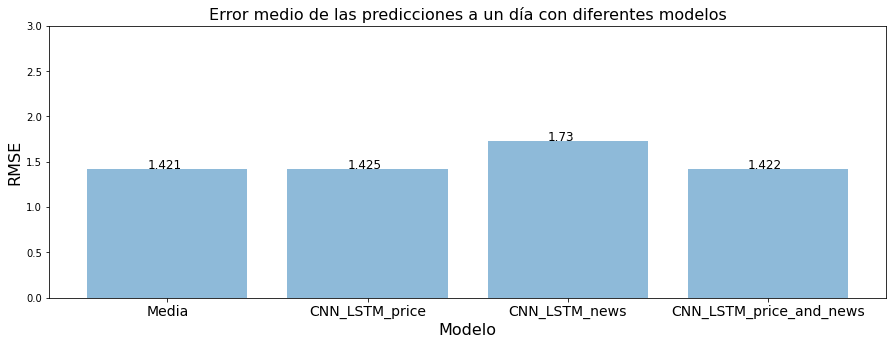

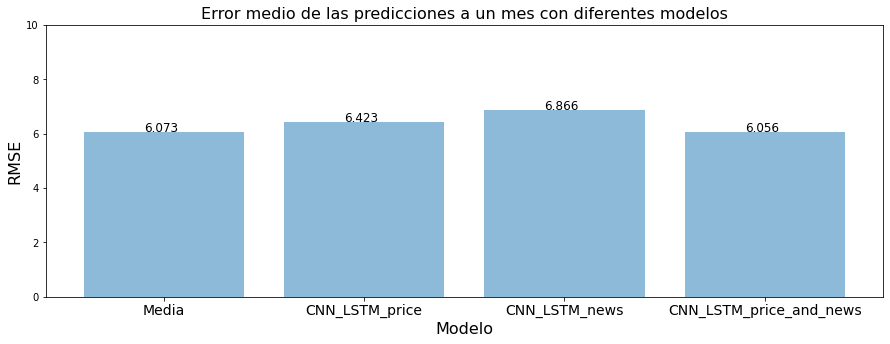

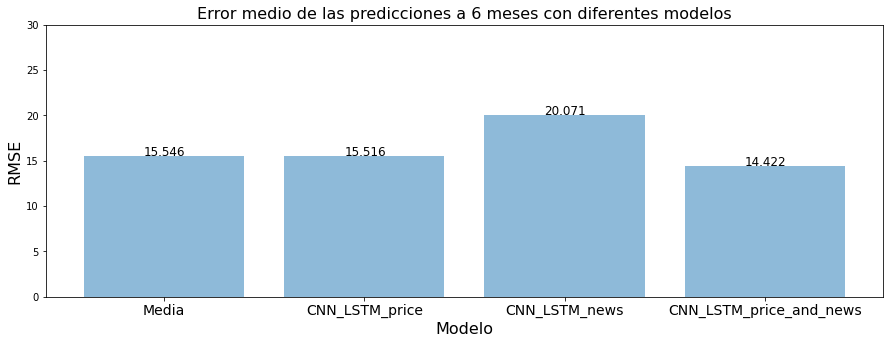

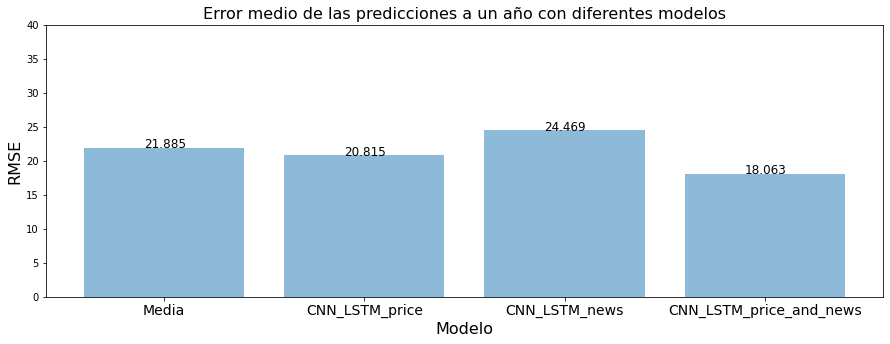

In [23]:
draw_results(averages['One_day_Y'], y_label, 'Modelo', 3, 'Error medio de las predicciones a un día con diferentes modelos')
draw_results(averages['month_Y'], y_label, 'Modelo', 10, 'Error medio de las predicciones a un mes con diferentes modelos')
draw_results(averages['6_months_Y'], y_label, 'Modelo', 30, 'Error medio de las predicciones a 6 meses con diferentes modelos')
draw_results(averages['year_Y'], y_label, 'Modelo', 40, 'Error medio de las predicciones a un año con diferentes modelos')

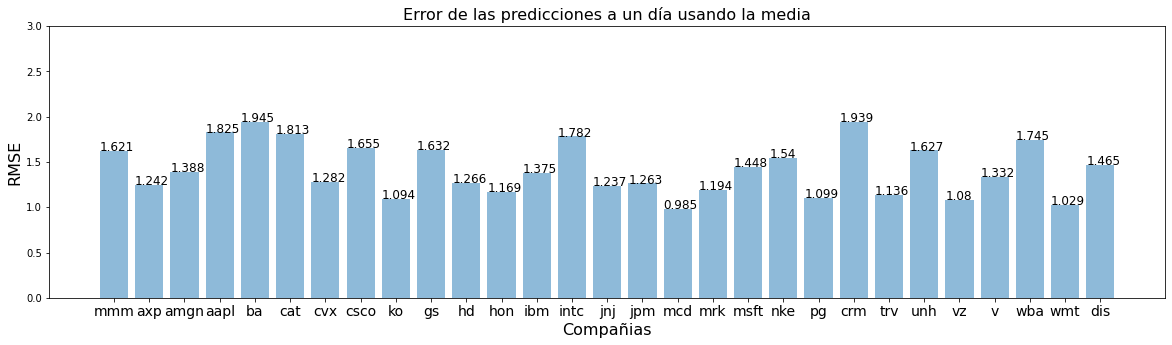

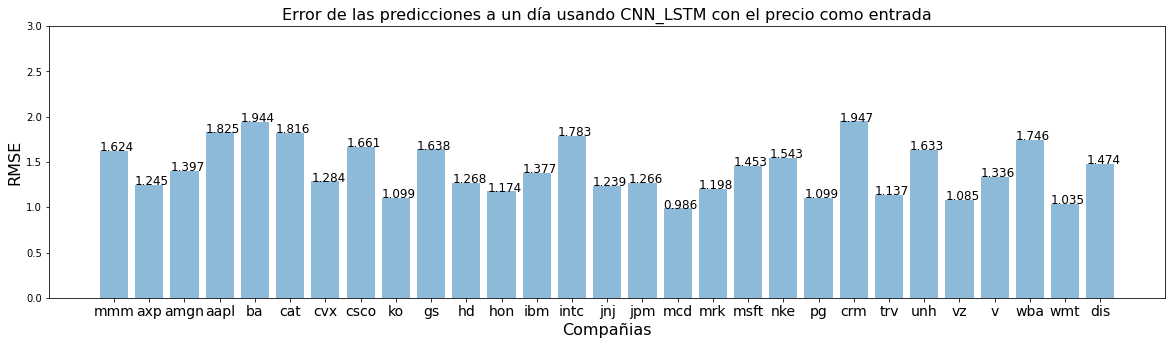

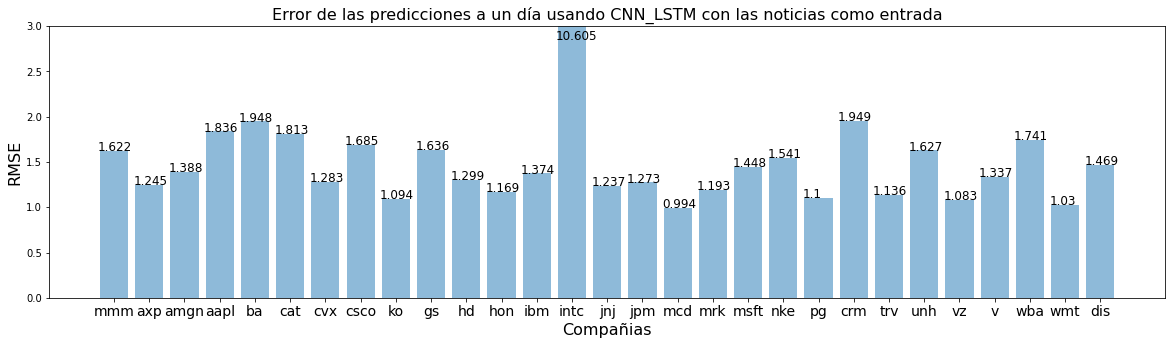

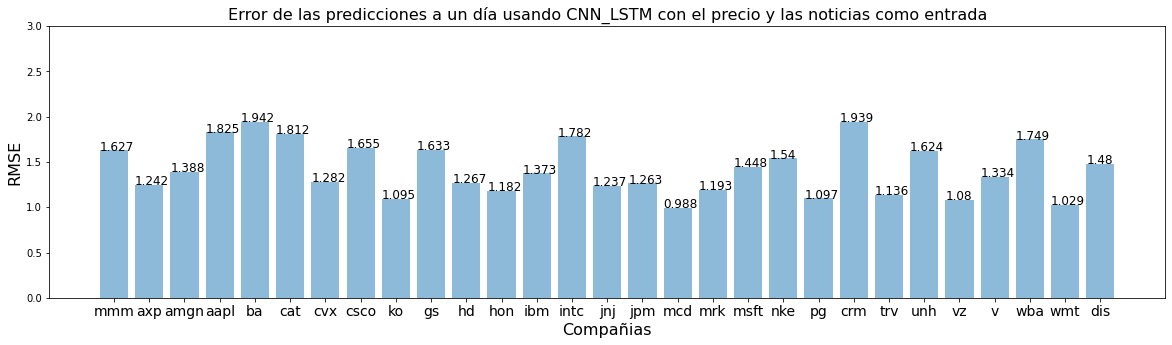

In [32]:
draw_results(all_rmse['One_day_Y']['Media'], y_label, x_label, 3, 'Error de las predicciones a un día usando la media')
draw_results(all_rmse['One_day_Y']['CNN_LSTM_price'], y_label, x_label, 3, 'Error de las predicciones a un día usando CNN_LSTM con el precio como entrada')
draw_results(all_rmse['One_day_Y']['CNN_LSTM_news'], y_label, x_label, 3, 'Error de las predicciones a un día usando CNN_LSTM con las noticias como entrada')
draw_results(all_rmse['One_day_Y']['CNN_LSTM_price_and_news'], y_label, x_label, 3, 'Error de las predicciones a un día usando CNN_LSTM con el precio y las noticias como entrada')

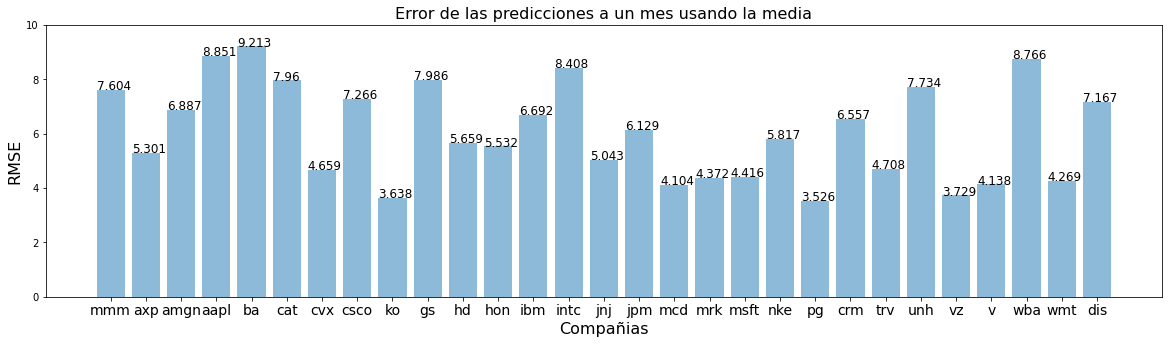

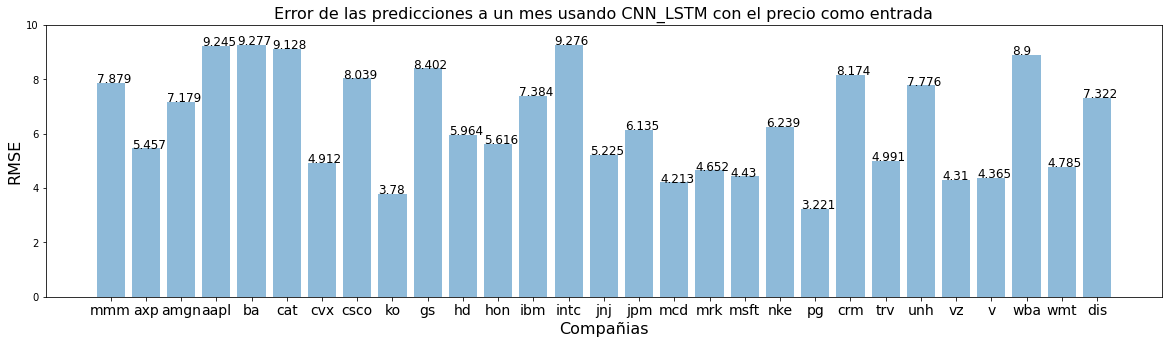

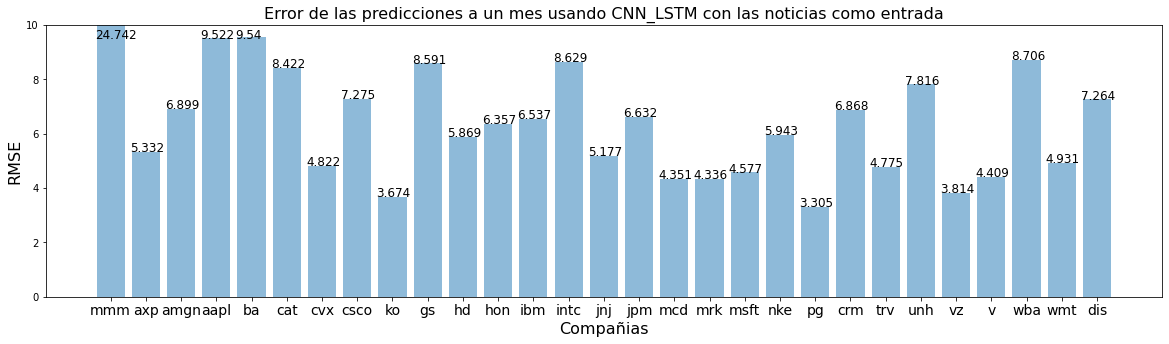

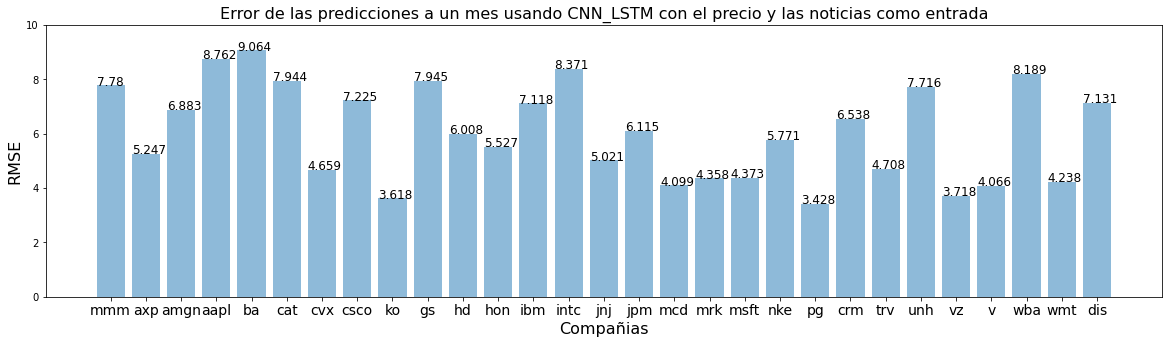

In [33]:
draw_results(all_rmse['month_Y']['Media'], y_label, x_label, 10, 'Error de las predicciones a un mes usando la media')
draw_results(all_rmse['month_Y']['CNN_LSTM_price'], y_label, x_label, 10, 'Error de las predicciones a un mes usando CNN_LSTM con el precio como entrada')
draw_results(all_rmse['month_Y']['CNN_LSTM_news'], y_label, x_label, 10, 'Error de las predicciones a un mes usando CNN_LSTM con las noticias como entrada')
draw_results(all_rmse['month_Y']['CNN_LSTM_price_and_news'], y_label, x_label, 10, 'Error de las predicciones a un mes usando CNN_LSTM con el precio y las noticias como entrada')

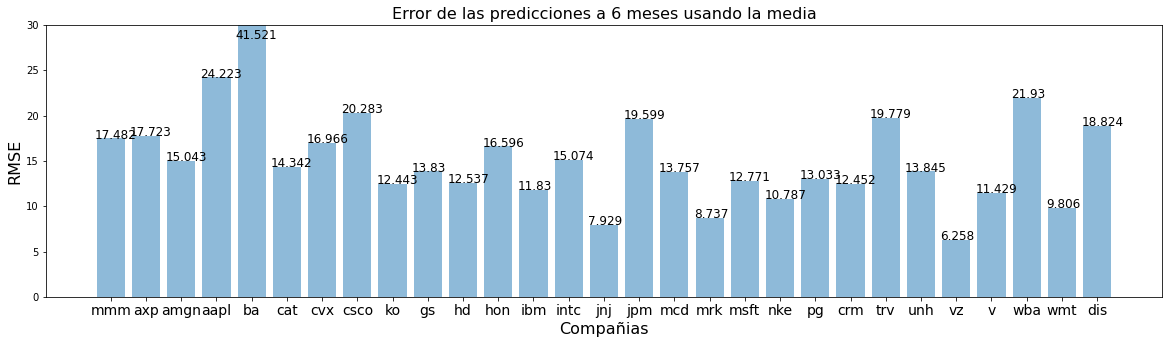

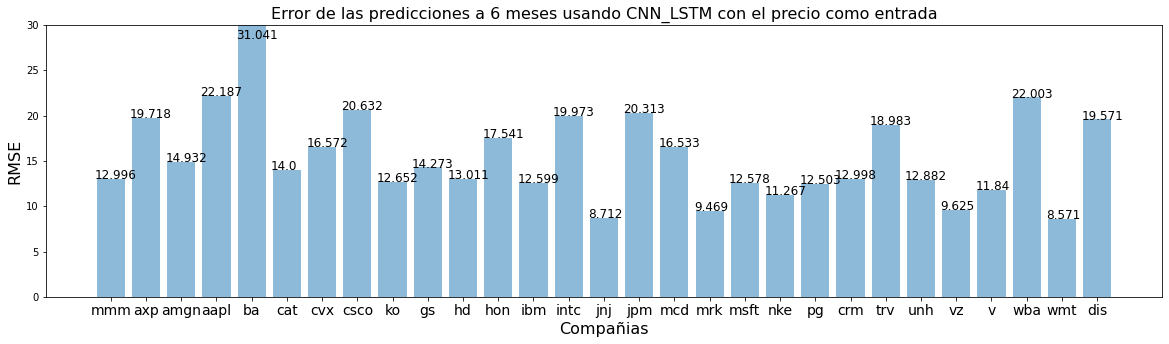

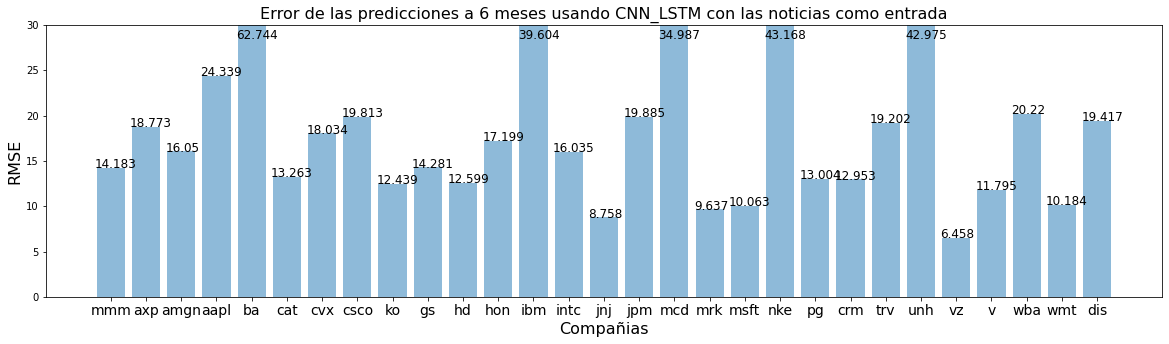

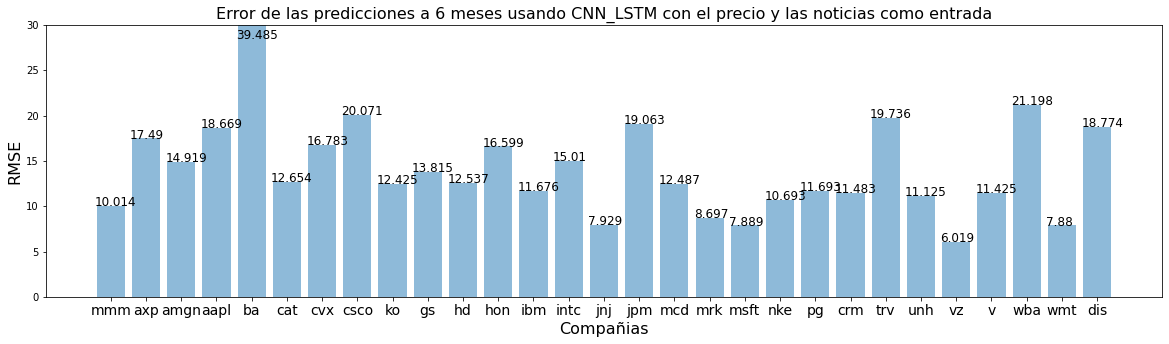

In [34]:
draw_results(all_rmse['6_months_Y']['Media'], y_label, x_label, 30, 'Error de las predicciones a 6 meses usando la media')
draw_results(all_rmse['6_months_Y']['CNN_LSTM_price'], y_label, x_label, 30, 'Error de las predicciones a 6 meses usando CNN_LSTM con el precio como entrada')
draw_results(all_rmse['6_months_Y']['CNN_LSTM_news'], y_label, x_label, 30, 'Error de las predicciones a 6 meses usando CNN_LSTM con las noticias como entrada')
draw_results(all_rmse['6_months_Y']['CNN_LSTM_price_and_news'], y_label, x_label, 30, 'Error de las predicciones a 6 meses usando CNN_LSTM con el precio y las noticias como entrada')

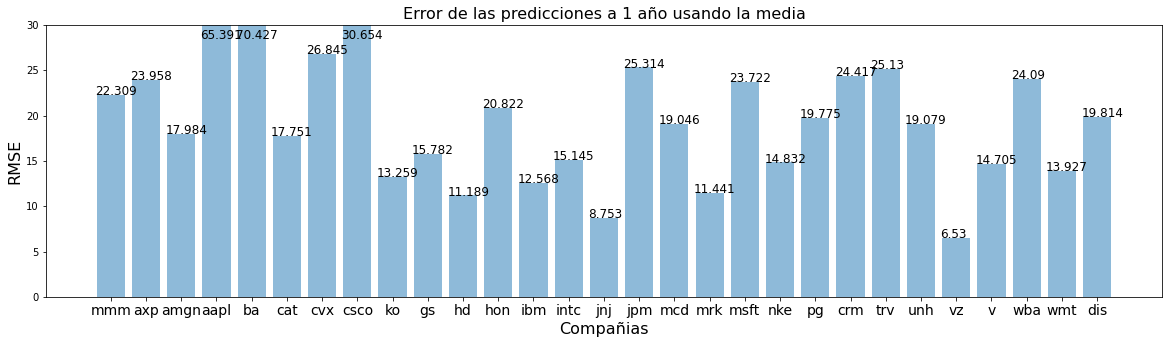

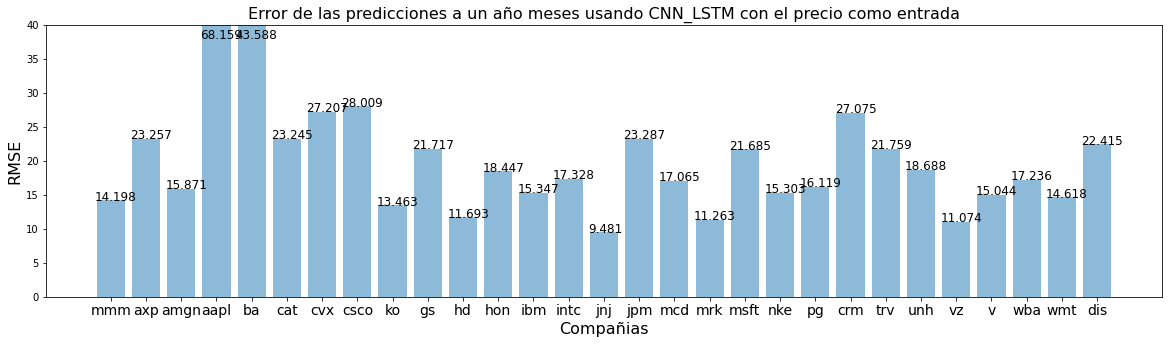

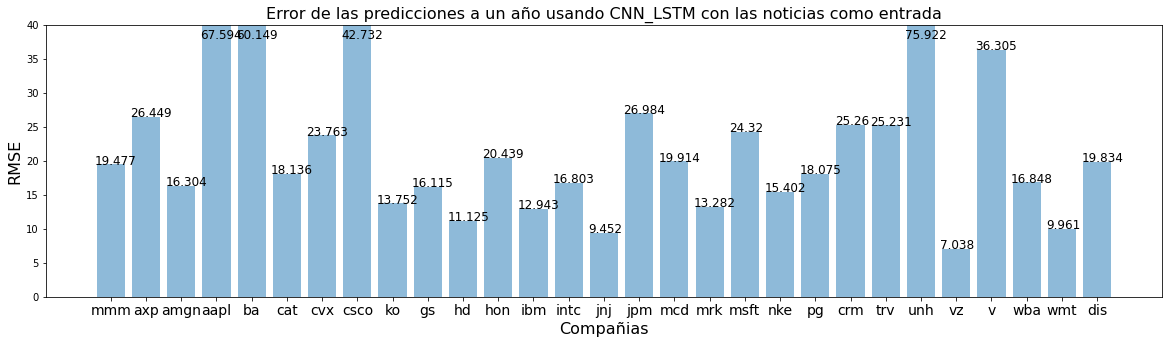

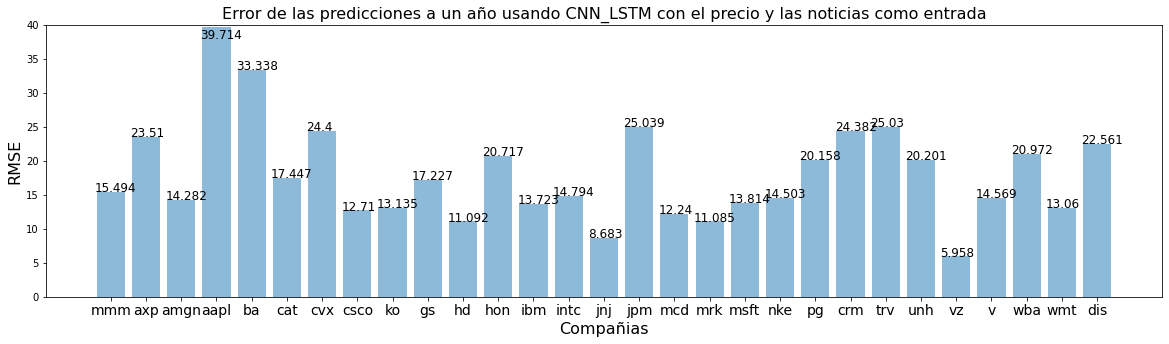

In [31]:
draw_results(all_rmse['year_Y']['Media'], y_label, x_label, 30, 'Error de las predicciones a 1 año usando la media')
draw_results(all_rmse['year_Y']['CNN_LSTM_price'], y_label, x_label, 40, 'Error de las predicciones a un año meses usando CNN_LSTM con el precio como entrada')
draw_results(all_rmse['year_Y']['CNN_LSTM_news'], y_label, x_label, 40, 'Error de las predicciones a un año usando CNN_LSTM con las noticias como entrada')
draw_results(all_rmse['year_Y']['CNN_LSTM_price_and_news'], y_label, x_label, 40, 'Error de las predicciones a un año usando CNN_LSTM con el precio y las noticias como entrada')